## Import packages and define some functions

In [13]:
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import scipy as scipy

from collections import Counter
import os

matplotlib.__version__, np.__version__, pd.__version__, sns.__version__, scipy.__version__
# show package versions

('3.9.2', '1.26.4', '2.2.2', '0.13.2', '1.13.1')

In [14]:
def get_dict_of_seq(fasta_file):
    """ function that converts a fasta file to a dictionnary of sequences
    fasta_file: the input fasta file
    """
    
    file_fasta_dict = {}
    # output dict of imported seqs
    
    with open(fasta_file, 'r') as fasta:    
        for line in fasta:
            # loops through the file

            if line.startswith('>') == True:
                seq_info = line.strip('>').strip('\n').split('\t')[0]
                file_fasta_dict[seq_info] = ''
                # checks if seq header

            else:
                file_fasta_dict[seq_info] += line.strip('\n')
                # If not, append nt to current seq
                
    return file_fasta_dict

complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}

## Custom regular expressions to find allele-scpecific target sites

In [15]:
nucleotide_codes = { 
                     'A': 'A',
                     'T': 'T',
                     'G': 'G',
                     'C': 'C',
                     'N' : '[ATGC]',
                     'W' : '[AT]',
                     'S': '[CG]',
                     'M': '[AC]',
                     'K': '[GT]',
                     'R': '[AG]',
                     'Y': '[CT]',
                     'B': '[CGT]',
                     'D': '[AGT]',
                     'H': '[ACT]',
                     'V': '[ACG]' }

rev_comp_codes = {   'A': 'T',
                     'T': 'A',
                     'G': 'C',
                     'C': 'G',
                     'N' : '[ATGC]',
                     'W' : '[AT]',
                     'S': '[CG]',
                     'M': '[TG]',
                     'K': '[CA]',
                     'R': '[TC]',
                     'Y': '[GA]',
                     'B': '[GCA]',
                     'D': '[TCA]',
                     'H': '[TGA]',
                     'V': '[TGC]' }

# dictionnaries to convert from IUPAC nucleotide codes to regex  

### Targeted nuclease properties: Cas9

In [16]:
guide_length = 20
PAM='NGG'
order = 'guide_first'
# Cas9 sgRNA properties

### Function to make regex from defined properties

In [17]:
def make_regex(guide_length, PAM, order):

    guide_regex = '[ATGC]{'+str(guide_length)+'}'
    # gRNA region

    PAM_regex = r''
    # empty container for PAM

    for code in PAM:
        PAM_regex+=nucleotide_codes[code]
    # make PAM

    if order == 'guide_first':
        regex = guide_regex+PAM_regex
    elif order == 'PAM_first':
        regex = PAM_regex+guide_regex
    # combine gRNA + PAM

    guide_regex_rev_comp = '[ATGC]{'+str(guide_length)+'}'
    PAM_regex_rev_comp = r''

    for code in PAM[::-1]:
        PAM_regex_rev_comp+=rev_comp_codes[code]

    if order == 'guide_first':
        regex_rev_comp = PAM_regex_rev_comp+guide_regex_rev_comp
    elif order == 'PAM_first':
        regex_rev_comp = guide_regex_rev_comp+PAM_regex_rev_comp
    # repeat for the same pattern but on the minus strand


    return regex, regex_rev_comp
    # return regex patterns

make_regex(guide_length, PAM, 'guide_first')
# test function with Cas9

('[ATGC]{20}[ATGC]GG', 'CC[ATGC][ATGC]{20}')

In [18]:
regex_cas9, regex_cas9_rev_comp = make_regex(guide_length, PAM, 'guide_first')
# makes regex for Cas9

In [19]:
ref_genome = get_dict_of_seq('./ref_genome_seq/C_albicans_SC5314_A22_current_chromosomes_no_breaks.fasta')


for k in list(ref_genome): 
    ref_genome[k.split(' ')[0]]=ref_genome.pop(k)


In [20]:
import regex as re

In [21]:
ref_genome.keys()

dict_keys(['Ca22chr1A_C_albicans_SC5314', 'Ca22chr1B_C_albicans_SC5314', 'Ca22chr2A_C_albicans_SC5314', 'Ca22chr2B_C_albicans_SC5314', 'Ca22chr3A_C_albicans_SC5314', 'Ca22chr3B_C_albicans_SC5314', 'Ca22chr4A_C_albicans_SC5314', 'Ca22chr4B_C_albicans_SC5314', 'Ca22chr5A_C_albicans_SC5314', 'Ca22chr5B_C_albicans_SC5314', 'Ca22chr6A_C_albicans_SC5314', 'Ca22chr6B_C_albicans_SC5314', 'Ca22chr7A_C_albicans_SC5314', 'Ca22chr7B_C_albicans_SC5314', 'Ca22chrM_C_albicans_SC5314', 'Ca22chrRA_C_albicans_SC5314', 'Ca22chrRB_C_albicans_SC5314'])

### Define invalid patterns to avoid in sgRNAs

In [22]:
invalid_patterns = []

poly_T = ['T'*x for x in range(4,21)]
poly_A = ['A'*x for x in range(5,21)]
poly_G = ['G'*x for x in range(4,21)]
poly_C = ['C'*x for x in range(5,21)]
# define sets of sequences to filter out of putative sgRNAs that would be problematic
# for synthesis or use, like homopolymers

invalid_patterns+=poly_T+poly_A+poly_C+poly_G
len(invalid_patterns)

66

In [23]:
invalid_patterns

['TTTT',
 'TTTTT',
 'TTTTTT',
 'TTTTTTT',
 'TTTTTTTT',
 'TTTTTTTTT',
 'TTTTTTTTTT',
 'TTTTTTTTTTT',
 'TTTTTTTTTTTT',
 'TTTTTTTTTTTTT',
 'TTTTTTTTTTTTTT',
 'TTTTTTTTTTTTTTT',
 'TTTTTTTTTTTTTTTT',
 'TTTTTTTTTTTTTTTTT',
 'TTTTTTTTTTTTTTTTTT',
 'TTTTTTTTTTTTTTTTTTT',
 'TTTTTTTTTTTTTTTTTTTT',
 'AAAAA',
 'AAAAAA',
 'AAAAAAA',
 'AAAAAAAA',
 'AAAAAAAAA',
 'AAAAAAAAAA',
 'AAAAAAAAAAA',
 'AAAAAAAAAAAA',
 'AAAAAAAAAAAAA',
 'AAAAAAAAAAAAAA',
 'AAAAAAAAAAAAAAA',
 'AAAAAAAAAAAAAAAA',
 'AAAAAAAAAAAAAAAAA',
 'AAAAAAAAAAAAAAAAAA',
 'AAAAAAAAAAAAAAAAAAA',
 'AAAAAAAAAAAAAAAAAAAA',
 'CCCCC',
 'CCCCCC',
 'CCCCCCC',
 'CCCCCCCC',
 'CCCCCCCCC',
 'CCCCCCCCCC',
 'CCCCCCCCCCC',
 'CCCCCCCCCCCC',
 'CCCCCCCCCCCCC',
 'CCCCCCCCCCCCCC',
 'CCCCCCCCCCCCCCC',
 'CCCCCCCCCCCCCCCC',
 'CCCCCCCCCCCCCCCCC',
 'CCCCCCCCCCCCCCCCCC',
 'CCCCCCCCCCCCCCCCCCC',
 'CCCCCCCCCCCCCCCCCCCC',
 'GGGG',
 'GGGGG',
 'GGGGGG',
 'GGGGGGG',
 'GGGGGGGG',
 'GGGGGGGGG',
 'GGGGGGGGGG',
 'GGGGGGGGGGG',
 'GGGGGGGGGGGG',
 'GGGGGGGGGGGGG',
 'GGGGGGGGGGGGGG

In [24]:
all_matches = []
matches_dict = {}
# containers for lists of re matches

for chromosome in list(ref_genome.keys()):
    matches_for = re.findall(regex_cas9, ref_genome[chromosome] , overlapped=True)
    # for each chromosome, find pattern matches for the gRNA+PAM re on the plus strand
    
    matches_rev = re.findall(regex_cas9_rev_comp, ref_genome[chromosome] , overlapped=True)
    matches_rev = ["".join(complement.get(base, base) for base in reversed(seq)) for seq  in matches_rev]
    # for each chromosome, find pattern matches for the gRNA+PAM re on the minus strand, and then reverse complement them

    matches_both = matches_for + matches_rev
    # combine both lists of pattern matches

    pre_filter = len(matches_both)
    # get total number of pattern matches

    for guide in matches_both[:]:
        for pattern in invalid_patterns:
            if pattern in guide:
                matches_both.remove(guide)
                break
    # loop through pattern matches, filter out those with invalid sequences as previously defined

    matches_dict[chromosome] = matches_both
    # add matches for each chromosome to a dictionary

    if 'M_C_' not in chromosome:
        print(chromosome, len(matches_for), len(matches_rev), pre_filter, len(matches_both))
        all_matches+=matches_both
        # filter out matches on the mitochondrial genome, and append matches to a genome-wide list



Ca22chr1A_C_albicans_SC5314 101329 101516 202845 145648
Ca22chr1B_C_albicans_SC5314 101316 101508 202824 145629
Ca22chr2A_C_albicans_SC5314 71461 72166 143627 103642
Ca22chr2B_C_albicans_SC5314 71393 72122 143515 103546
Ca22chr3A_C_albicans_SC5314 58126 58699 116825 83325
Ca22chr3B_C_albicans_SC5314 58140 58745 116885 83332
Ca22chr4A_C_albicans_SC5314 51363 51315 102678 73812
Ca22chr4B_C_albicans_SC5314 51429 51330 102759 73762
Ca22chr5A_C_albicans_SC5314 38013 38758 76771 54575
Ca22chr5B_C_albicans_SC5314 38021 38761 76782 54654
Ca22chr6A_C_albicans_SC5314 33487 34070 67557 49061
Ca22chr6B_C_albicans_SC5314 33541 33939 67480 49041
Ca22chr7A_C_albicans_SC5314 31162 31091 62253 44397
Ca22chr7B_C_albicans_SC5314 31158 31083 62241 44391
Ca22chrRA_C_albicans_SC5314 75317 75107 150424 107823
Ca22chrRB_C_albicans_SC5314 75309 75086 150395 107791


In [25]:
all_unique_matches = set(all_matches)
len(all_unique_matches)
# use set operations to determined the number of unique matches across the genome

704591

### Align matches on the genome

In [26]:
with open('./allele_specific_targets.fa', 'a') as dest:
    # open destination FASTA file

    count_file = 0
    # counter to keep track of the number of sgRNAs written down
    
    for chr_pair in ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chrR']:
    
        matches_A = matches_dict['Ca22'+chr_pair+'A_C_albicans_SC5314']
        matches_B = matches_dict['Ca22'+chr_pair+'B_C_albicans_SC5314']
    
        unique_A = set(matches_A)&all_unique_matches
        unique_B = set(matches_B)&all_unique_matches
            
        unique_either_A_or_B = unique_A^unique_B
    
        unique_specific_to_A = unique_either_A_or_B&unique_A
        unique_specific_to_B = unique_either_A_or_B&unique_B
        # use set operations to find sgRNAs unique to either chromosome A or B as well as those
        # specific to one chromosome

        count_A = 1
        

        for guide_loc in unique_specific_to_A:
            header = '>'+chr_pair+'A_'+format(count_A, '05')+'\n'
            seq = guide_loc
            # define an ID for a sgRNA target and generate a FASTA header, for A matches

            if count_file != 0:
                dest.write('\n')
            # change behaviour for first line
                
            dest.write(header)
            dest.write(seq)
            count_A+=1
            count_file+=1
            # write to file and update counts

        count_B = 1

        for guide_loc in unique_specific_to_B:
            header = '>'+chr_pair+'B_'+format(count_B, '05')+'\n'
            seq = guide_loc
            # define an ID for a sgRNA target and generate a FASTA header, for A matches

            if count_file != 0:
                dest.write('\n')
            # change behaviour for first line
                
            dest.write(header)
            dest.write(seq)
            count_B+=1
             # write to file and update counts
            
            
       
        print(len(unique_A), len(unique_B), len(unique_A^unique_B), len(unique_either_A_or_B&unique_A), len(unique_either_A_or_B&unique_B))    

144918 144961 28619 14288 14331
102798 102749 19913 9981 9932
81890 81904 7676 3831 3845
72781 72819 15654 7808 7846
54180 54250 12778 6354 6424
47601 47612 13813 6901 6912
43611 43613 3058 1528 1530
105992 105954 15870 7954 7916


### Calls for alignments, pileup, and feature counts

## Statistics on guide mapping (Cas9)

In [27]:
chrom_guide_count = Counter()
chrom_dist_list_dict = {}
chrom_pos_list_dict = {}
# Containers for sgRNA stats

with open('./allele_specific.sorted.sam', 'r') as source:
# open alignment
    
    current_chrom = ''
    current_pos = ''
    # empty container

    for line in source:
        if line.startswith('@')==False:
            line_info = line.split('\t')
            if line_info[1] != '4':
                chrom_mapping = line_info[2].split('_')[0].replace('Ca22', '')
                map_pos = int(line_info[3])
        # go through valid alignments and get info

                if current_chrom != chrom_mapping:
                    chrom_dist_list_dict[chrom_mapping] = []
                    chrom_pos_list_dict[chrom_mapping] = []
                    current_chrom = chrom_mapping
                    current_pos = map_pos
                    # generate empty containers and variables to measure the distance between hits
                    
                    chrom_pos_list_dict[chrom_mapping]+=[current_pos]
                    
                else:
                
                    distance = map_pos-current_pos
                    chrom_dist_list_dict[current_chrom]+=[distance]
                    current_pos = map_pos
                    chrom_pos_list_dict[chrom_mapping]+=[current_pos]
                    # get distance and update variables. Add it to the Chr specific distribution
                        
    
                chrom_guide_count[chrom_mapping]+=1
            

In [28]:
chr_len_dict = {'chr1A': 3188341,
                'chr1B': 3188396,
                'chr2A': 2231883,
                'chr2B': 2231750,
                'chr3A': 1799297,
                'chr3B': 1799270,
                'chr4A': 1603259,
                'chr4B': 1603311,
                'chr5A': 1190869,
                'chr5B': 1190991,
                'chr6A': 1033292,
                'chr6B': 1033212,
                'chr7A': 949580,
                'chr7B': 949611,
                'chrRA': 2286237,
                'chrRB': 2285697}

### Rolling windows for sgRNA density

In [29]:
chr_len_dict = {'chr1A': 3188341,
                'chr1B': 3188396,
                'chr2A': 2231883,
                'chr2B': 2231750,
                'chr3A': 1799297,
                'chr3B': 1799270,
                'chr4A': 1603259,
                'chr4B': 1603311,
                'chr5A': 1190869,
                'chr5B': 1190991,
                'chr6A': 1033292,
                'chr6B': 1033212,
                'chr7A': 949580,
                'chr7B': 949611,
                'chrRA': 2286237,
                'chrRB': 2285697}
# dict of chr lengths

In [30]:
dict_of_dict_n_guides = {}
# container to build a DataFrame of the number of sgRNAs per (rolling) window in the genome

for chrom in sorted(chr_len_dict.keys()):
    chrom_len = chr_len_dict[chrom]
    dict_of_dict_n_guides[chrom] = {}
    # loop through chromosome and generate empty containers

    n_windows = round(chrom_len/200)
    windows = np.linspace(1,chrom_len+1,n_windows+1)
    window_index = 0
    # generate 200bp windows: rolling counts over 1kb 

    for window in range(0, len(windows)-1):
        start = windows[window]
        end = windows[window+1]
        n_guides_in_window = len([x for x in chrom_pos_list_dict[chrom] if x >=start and x < end])
        dict_of_dict_n_guides[chrom][window_index] = n_guides_in_window
        window_index+=1
        # get counts for window, update variables
        
    
    print(len(windows))

15943
15943
11160
11160
8997
8997
8017
8018
5955
5956
5167
5167
4749
4749
11432
11429


In [31]:
n_guides_df = pd.DataFrame(dict_of_dict_n_guides)
n_guides_df
# make DataFrame

,chr1A,chr1B,chr2A,chr2B,chr3A,chr3B,chr4A,chr4B,chr5A,chr5B,chr6A,chr6B,chr7A,chr7B,chrRA,chrRB
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15937,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15938,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15939,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15940,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
rolling_sum_df = n_guides_df.rolling(5).sum()
rolling_sum_df
# rolling sum of guides in 5 kb regions from 5x200bp windows

,chr1A,chr1B,chr2A,chr2B,chr3A,chr3B,chr4A,chr4B,chr5A,chr5B,chr6A,chr6B,chr7A,chr7B,chrRA,chrRB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15937,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15938,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15939,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15940,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Figure S1

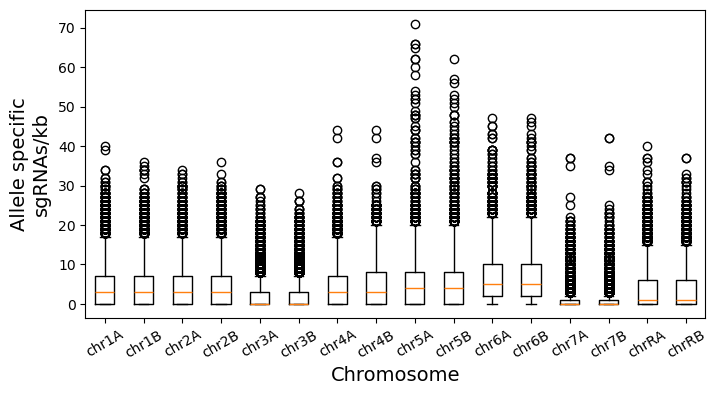

In [34]:
plt.figure(figsize=(8,4))

plt.boxplot([rolling_sum_df[x].dropna() for x in sorted(chr_len_dict.keys())])



plt.ylabel('Allele specific\nsgRNAs/kb', fontsize=14, labelpad=5, loc='center')
plt.xlabel('Chromosome', fontsize=14)


plt.xticks(range(1,17), sorted(chr_len_dict.keys()), rotation=30)




plt.savefig('./figures/target_density.svg', format='svg', dpi=300, bbox_inches='tight')
plt.savefig('./figures/target_density.png', format='png', dpi=300, bbox_inches='tight')

### sgRNA per allele

In [35]:

n_sgRNA_per_allele = Counter()


with open('./read_map.counts', 'r') as source:
    for line in source:
        if line.startswith('#')==False and line.startswith('Geneid')==False:
            line = line.strip('\n')
            line_info = line.split('\t')
            target = line_info[0].split('-')[0]
            n_sgrna = int(line_info[6])
            n_sgRNA_per_allele[target]+=n_sgrna
            # get per allele info for Cas9
            
            

In [36]:
chr_coord_SNP = []
chr_coord_coding_SNP = []

all_sites = 0
SNP_count = 0
coding_SNP_count = 0

with open('./ref_genome_seq/C_albicans_SC5314_haplotype_variations.tab', 'r') as source:
    for line in source:
        if line.startswith('Hap A')==False:
            line_info=line.split('\t')
            chr_A = line_info[0]
            chr_B = line_info[3]
        # open file, skip header and get info

            if chr_A.strip('Ca22chr').strip('A_C_albicans_SC5314') != chr_B.strip('Ca22chr').strip('B_C_albicans_SC5314'):
                print(line)
                # all heterozygous sites are matched in terms of chromosome

            if line_info[6] == '1 nt subs':
                SNP_count+=1
                # only look at SNPs

                chr_A_pos = str(int(line_info[2]) - 1)
                chr_B_pos = str(int(line_info[5]) - 1)

                chr_A_coord = chr_A+'_'+chr_A_pos
                chr_B_coord = chr_B+'_'+chr_B_pos

                chr_coord_SNP.append(chr_A_coord)
                chr_coord_SNP.append(chr_B_coord)
                # get SNP chromosome position info for both A and B

                if line_info[9] != 'intergenic\n':
                    chr_coord_coding_SNP.append(chr_A_coord)
                    chr_coord_coding_SNP.append(chr_B_coord)
                    coding_SNP_count+=1
                    # add filter to get info coding sequence specific SNPS
                    
                    

            all_sites+=1

In [37]:
all_sites, SNP_count, coding_SNP_count

(64558, 50427, 28169)

## Find target sites for Cas12a (Cpf1)

In [38]:
regex_cas12, regex_cas12_rev_comp = make_regex(20, 'TTTV', 'PAM_first')
# Cas9 sgRNA properties

In [39]:
regex_cas12, regex_cas12_rev_comp

('TTT[ACG][ATGC]{20}', '[ATGC]{20}[TGC]AAA')

In [40]:
all_matches_cas12 = []
matches_dict_cas12 = {}
# containers for lists of re matches


for chromosome in list(ref_genome.keys()):
    matches_for = re.findall(regex_cas12, ref_genome[chromosome] , overlapped=True)
    # for each chromosome, find pattern matches for the gRNA+PAM re on the plus strand

    matches_rev = re.findall(regex_cas12_rev_comp, ref_genome[chromosome] , overlapped=True)
    matches_rev = ["".join(complement.get(base, base) for base in reversed(seq)) for seq  in matches_rev]
    # for each chromosome, find pattern matches for the gRNA+PAM re on the minus strand, and then reverse complement them

    matches_both = matches_for + matches_rev
    # combine both lists of pattern matches

    pre_filter = len(matches_both)
    # get total number of pattern matches

    for guide in matches_both[:]:
        for pattern in invalid_patterns:
            if pattern in guide:
                matches_both.remove(guide)
                break
    # loop through pattern matches, filter out those with invalid sequences as previously defined

    matches_dict_cas12[chromosome] = matches_both
    # add matches for each chromosome to a dictionary

    if 'M_C_' not in chromosome:
        print(chromosome, len(matches_for), len(matches_rev), pre_filter, len(matches_both))
        all_matches_cas12+=matches_both
        # filter out matches on the mitochondrial genome, and append matches to a genome-wide list

len(all_matches_cas12)

Ca22chr1A_C_albicans_SC5314 91793 91696 183489 131087
Ca22chr1B_C_albicans_SC5314 91808 91637 183445 131068
Ca22chr2A_C_albicans_SC5314 63597 63740 127337 91386
Ca22chr2B_C_albicans_SC5314 63551 63767 127318 91386
Ca22chr3A_C_albicans_SC5314 51166 51295 102461 72923
Ca22chr3B_C_albicans_SC5314 51160 51294 102454 72867
Ca22chr4A_C_albicans_SC5314 45166 45726 90892 65183
Ca22chr4B_C_albicans_SC5314 45129 45732 90861 65147
Ca22chr5A_C_albicans_SC5314 34217 33767 67984 48459
Ca22chr5B_C_albicans_SC5314 34180 33795 67975 48451
Ca22chr6A_C_albicans_SC5314 28792 29029 57821 41581
Ca22chr6B_C_albicans_SC5314 28791 29039 57830 41598
Ca22chr7A_C_albicans_SC5314 26784 26632 53416 38650
Ca22chr7B_C_albicans_SC5314 26780 26621 53401 38624
Ca22chrRA_C_albicans_SC5314 64108 65494 129602 92485
Ca22chrRB_C_albicans_SC5314 64148 65559 129707 92534


1163429

In [41]:
all_unique_matches_cas12 = set(all_matches_cas12)
len(all_matches_cas12)

1163429

In [42]:
with open('./allele_specific_targets_cas12a.fa', 'a') as dest:
     # open destination FASTA file

    count_file = 0
    # counter to keep track of the number of sgRNAs written down
    
    for chr_pair in ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chrR']:
    
        matches_A = matches_dict_cas12['Ca22'+chr_pair+'A_C_albicans_SC5314']
        matches_B = matches_dict_cas12['Ca22'+chr_pair+'B_C_albicans_SC5314']
    
        unique_A = set(matches_A)&all_unique_matches_cas12
        unique_B = set(matches_B)&all_unique_matches_cas12
    
        unique_either_A_or_B = unique_A^unique_B
    
        unique_specific_to_A = unique_either_A_or_B&unique_A
        unique_specific_to_B = unique_either_A_or_B&unique_B
        # use set operations to find sgRNAs unique to either chromosome A or B as well as those
        # specific to one chromosome

        count_A = 1
        

        for guide_loc in unique_specific_to_A:
            header = '>'+chr_pair+'A_'+format(count_A, '05')+'\n'
            seq = guide_loc
            # define an ID for a sgRNA target and generate a FASTA header, for A matches

            if count_file != 0:
                dest.write('\n')
            # change behaviour for first line
                
            dest.write(header)
            dest.write(seq)
            count_A+=1
            count_file+=1
            # write to file and update counts

        count_B = 1

        for guide_loc in unique_specific_to_B:
            header = '>'+chr_pair+'B_'+format(count_B, '05')+'\n'
            seq = guide_loc
            # define an ID for a sgRNA target and generate a FASTA header, for B matches

            if count_file != 0:
                dest.write('\n')
            # change behaviour for first line
                
            dest.write(header)
            dest.write(seq)
            count_B+=1
            # write to file and update counts
            
            
       
        print(len(unique_A), len(unique_B), len(unique_A^unique_B), len(unique_either_A_or_B&unique_A), len(unique_either_A_or_B&unique_B))    

130641 130629 26280 13146 13134
90960 90991 17705 8837 8868
72246 72195 7125 3588 3537
64551 64555 13938 6967 6971
48266 48256 11692 5851 5841
40994 41002 11494 5743 5751
38073 38032 2647 1344 1303
91450 91494 15112 7534 7578


In [43]:
n_sgRNA_per_allele_cas12 = Counter()

with open('./read_map_cas12.counts', 'r') as source:
    for line in source:
        if line.startswith('#')==False and line.startswith('Geneid')==False:
            line = line.strip('\n')
            line_info = line.split('\t')
            target = line_info[0].split('-')[0]
            n_sgrna = int(line_info[6])

            n_sgRNA_per_allele_cas12[target]+=n_sgrna

In [44]:
both_enzymes = [n_sgRNA_per_allele[x]+n_sgRNA_per_allele_cas12[x] for x in list(n_sgRNA_per_allele.keys())]
# generate a cumulative distribution that includes both enzymes

In [45]:
cas9_mapped_unmapped = [72119, 42757]
sum([72119, 42757])
#values from featureCounts for coding vs non-coding alignments

114876

In [46]:
cas12_mapped_unmapped = [54527, 49728]
sum([54527, 49728])
#values from featureCounts

104255

### Figure 5C

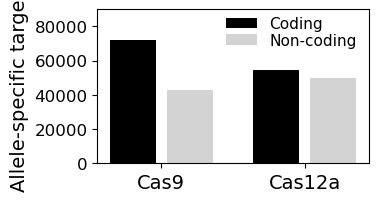

In [48]:
plt.figure(figsize=(3.5,2))

plt.bar(x=[0], height=[72119], color=['k'])
plt.bar(x=[1], height=[42757], color=['lightgrey'])

plt.bar(x=[2.5], height=[54527], color=['k'])
plt.bar(x=[3.5], height=[49728], color=['lightgrey'])



plt.legend(['Coding', 'Non-coding'], fontsize=11, loc=(0.475,0.75), frameon=False, borderpad=0, labelspacing =0.1,borderaxespad =0)

plt.xticks([0.5,3], ['Cas9', 'Cas12a'], fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel('Allele-specific targets', fontsize=14)
plt.ylim(0, 90000)





plt.savefig('./figures/coding_non_coding.svg', format='svg', dpi=300, bbox_inches='tight')

## Import Cas9 pileup

In [49]:
cas9_coverage_counter = Counter()

with open('cas9_pileup.txt', 'r') as source:
    
    for line in source:
        line_info = line.split('\t')

        chr_wcoord = line_info[0]+'_'+line_info[1]
        coverage = int(line_info[3])

        cas9_coverage_counter[chr_wcoord]+=coverage


In [50]:
coverage_dist_cas9 = []
coverage_dist_coding_cas9 = []

for SNP in chr_coord_SNP:
    coverage_dist_cas9.append(cas9_coverage_counter[SNP])

for coding_SNP in chr_coord_coding_SNP:
    coverage_dist_coding_cas9.append(cas9_coverage_counter[coding_SNP])

In [51]:
max(coverage_dist_cas9), max(coverage_dist_coding_cas9)

(14, 9)

## Distance to nearest site

In [52]:
n_absent = 0

distance_to_next_site = []

closest_sgRNA_dict = {}

for SNP in chr_coord_SNP:
    coverage = cas9_coverage_counter[SNP]

    SNP_coord = int(SNP.split('_')[4])

    close_target_found = 0
    
    if coverage == 0:
        n_absent+=1

               
        for x in range(1,501):
            upstream_coord = SNP_coord-x
            upstream_coverage = cas9_coverage_counter['_'.join(SNP.split('_')[0:4]+[str(upstream_coord)])]
            if upstream_coverage != 0:
                close_target_found = 1
                closest_sgRNA_dict[SNP] = '_'.join(SNP.split('_')[0:4]+[str(upstream_coord)])
                distance_to_next_site.append(x)
                break
                
            downstream_coord = SNP_coord+x
            downstream_coverage = cas9_coverage_counter['_'.join(SNP.split('_')[0:4]+[str(downstream_coord)])]
            if downstream_coverage != 0:
                close_target_found = 1
                closest_sgRNA_dict[SNP] = '_'.join(SNP.split('_')[0:4]+[str(downstream_coord)])
                distance_to_next_site.append(x)
                break


            #if cas9_coverage_counter[SNP_coord[0:4]+[str(upstream_coord)]]
            

In [53]:
len(coverage_dist_cas9), coverage_dist_cas9.count(0), 18111, 26694, 37550, 42854
# initial                       0 coverage           <=50  <=100  <=250  <=500

(100854, 45707, 18111, 26694, 37550, 42854)

### Figure 5B

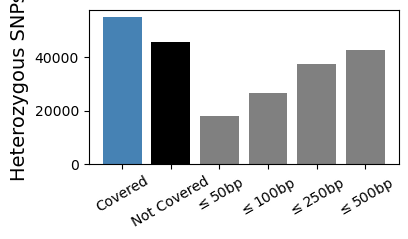

In [55]:
plt.figure(figsize=(4,2))

plt.bar([0,1,2,3,4,5], [len(coverage_dist_cas9)-coverage_dist_cas9.count(0), coverage_dist_cas9.count(0), 18111, 26694, 37550, 42854],
       color=['steelblue', 'black', 'grey', 'grey', 'grey', 'grey'])

plt.xticks([0,1,2,3,4,5], [r'Covered', 'Not Covered', r'$\leq$50bp', r'$\leq$100bp', r'$\leq$250bp', r'$\leq$500bp'], rotation=30)
plt.ylabel('Heterozygous SNPs', fontsize=14)

plt.savefig('./figures/coverage_cas9.svg', format='svg', dpi=300, bbox_inches='tight')

In [56]:
42854/45707

0.9375806769203842

## Make Cas9 table

In [57]:
cas9_coverage_pos_sgRNA_ID = {}

with open('cas9_pileup.txt', 'r') as source:
    
    for line in source:
        line_info = line.split('\t')

        chr_wcoord = line_info[0]+'_'+line_info[1]
        coverage = int(line_info[3])
        sgRNA_ID_list = line_info[6].strip('\n').split(',')

        cas9_coverage_pos_sgRNA_ID[chr_wcoord]=sgRNA_ID_list

In [58]:
cas9_sgRNA_dict = get_dict_of_seq('./allele_specific_targets.fa')

In [59]:
cas9_coverage_pos_sgRNA_ID[chr_wcoord]

['chrRB_02133']

In [60]:
all_sites=0

with open('./cas9_sgRNA_table.tsv', 'w') as dest:

    with open('./ref_genome_seq/C_albicans_SC5314_haplotype_variations.tab', 'r') as source:

        dest.write('Hap A Chromosome\tHap A Upstream Coord\tHap A Downstream Coord\tHap B Chromosome\tHap B Upstream Coord\tHap B Downstream Coord\tChange Type\tHap A Seq\tHap B Seq\tAffected Features\tsgRNAs_chrA\tnearest_sgRNA_chrA\tsgRNAs_chrB\tnearest_sgRNA_chrB\n')
        
        index = 0
        for line in source:
            if line.startswith('Hap A')==False:
                line_info=line.strip('\n').split('\t')
                chr_A = line_info[0]
                chr_B = line_info[3]
                snp_loc = 'coding'
                
                if chr_A.strip('Ca22chr').strip('A_C_albicans_SC5314') != chr_B.strip('Ca22chr').strip('B_C_albicans_SC5314'):
                    print(line)
                    # all heterozygous sites are matched in terms of chromosome
    
                if line_info[9] == 'intergenic':
                        chr_coord_coding_SNP.append(chr_A_coord)
                        chr_coord_coding_SNP.append(chr_B_coord)
                        coding_SNP_count+=1
    
                if line_info[6] == '1 nt subs':
                  
                    chr_A_pos = str(int(line_info[2]) - 1)
                    chr_B_pos = str(int(line_info[5]) - 1)
    
                    chr_A_coord = chr_A+'_'+chr_A_pos
                    chr_B_coord = chr_B+'_'+chr_B_pos
    
                    chr_coord_SNP.append(chr_A_coord)
                    chr_coord_SNP.append(chr_B_coord)

                    on_chr_A = ['NA']
                    near_chr_A = ['NA']

                    on_chr_B = ['NA']
                    near_chr_B = ['NA']
    
                    if chr_A_coord in cas9_coverage_pos_sgRNA_ID.keys():
                        sgRNA_list = cas9_coverage_pos_sgRNA_ID[chr_A_coord]

                        on_chr_A = [x+':'+cas9_sgRNA_dict[x] for x in sgRNA_list]
                        if len(on_chr_A)==14:
                            print(on_chr_A)
                            print(';'.join(on_chr_A))

                        index+=1

                    elif chr_A_coord in closest_sgRNA_dict.keys():
                        sgRNA_list = cas9_coverage_pos_sgRNA_ID[closest_sgRNA_dict[chr_A_coord]]
                        near_chr_A = [x+':'+cas9_sgRNA_dict[x] for x in sgRNA_list]
                        index+=1

                    if chr_B_coord in cas9_coverage_pos_sgRNA_ID.keys():
                        sgRNA_list = cas9_coverage_pos_sgRNA_ID[chr_B_coord]

                        on_chr_B = [x+':'+cas9_sgRNA_dict[x] for x in sgRNA_list]
    
                        index+=1

                    elif chr_B_coord in closest_sgRNA_dict.keys():
                        sgRNA_list = cas9_coverage_pos_sgRNA_ID[closest_sgRNA_dict[chr_B_coord]]
                        near_chr_B = [x+':'+cas9_sgRNA_dict[x] for x in sgRNA_list]
                        index+=1
                    
                    line_info.append(';'.join(on_chr_A))
                    line_info.append(';'.join(near_chr_A))
                    
                    line_info.append(';'.join(on_chr_B))
                    line_info.append(';'.join(near_chr_B))

                    to_write = '\t'.join(line_info)+'\n'

                    dest.write(to_write)
                    
                    
                    

            all_sites+=1

['chr6A_00316:ATTGAGATCCATGCCGCTAGTGG', 'chr6A_01873:TGTTGAACTACCGGAATTGCCGG', 'chr6A_06337:TCGCCCATCATCTAGTTTGAAGG', 'chr6A_01754:TCTCCCTTTGGCGCGTCAATTGG', 'chr6A_04855:ATTAGTTATTGATGGTAAACTGG', 'chr6A_02224:AAGTTCAATGATCTCATAACTGG', 'chr6A_04760:AAGTAGTTATTATATCAGATCGG', 'chr6A_06054:AACCACATCCTAAAATTATAAGG', 'chr6A_05349:ATTGGTCATTTATGTAGGTAAGG', 'chr6A_02254:CTACAGCGTCAAGGAGGACAGGG', 'chr6A_05622:CTTGACTTGTGGCGGATTGATGG', 'chr6A_06325:AATGTAGTTGCGTTCGATGAAGG', 'chr6A_04341:CAATGTAAATCACCTTTAGTTGG', 'chr6A_01748:CACCCTTTCACAAGGCAAGCTGG']
chr6A_00316:ATTGAGATCCATGCCGCTAGTGG;chr6A_01873:TGTTGAACTACCGGAATTGCCGG;chr6A_06337:TCGCCCATCATCTAGTTTGAAGG;chr6A_01754:TCTCCCTTTGGCGCGTCAATTGG;chr6A_04855:ATTAGTTATTGATGGTAAACTGG;chr6A_02224:AAGTTCAATGATCTCATAACTGG;chr6A_04760:AAGTAGTTATTATATCAGATCGG;chr6A_06054:AACCACATCCTAAAATTATAAGG;chr6A_05349:ATTGGTCATTTATGTAGGTAAGG;chr6A_02254:CTACAGCGTCAAGGAGGACAGGG;chr6A_05622:CTTGACTTGTGGCGGATTGATGG;chr6A_06325:AATGTAGTTGCGTTCGATGAAGG;chr6A_04341:CAATGTAAA

## Import Cas12 pileup

In [61]:
cas12_coverage_counter = Counter()

with open('cas12_pileup.txt', 'r') as source:
    
    for line in source:
        line_info = line.split('\t')

        chr_wcoord = line_info[0]+'_'+line_info[1]
        coverage = int(line_info[3])

        cas12_coverage_counter[chr_wcoord]+=coverage
        

In [62]:
coverage_dist_cas12 = []
coverage_dist_coding_cas12 = []

for SNP in chr_coord_SNP:
    coverage_dist_cas12.append(cas12_coverage_counter[SNP])

for coding_SNP in chr_coord_coding_SNP:
    coverage_dist_coding_cas12.append(cas12_coverage_counter[coding_SNP])

In [63]:
max(coverage_dist_cas12), max(coverage_dist_coding_cas12)


(7, 7)

In [64]:
cas12_coverage_pos_sgRNA_ID = {}

with open('cas12_pileup.txt', 'r') as source:
    
    for line in source:
        line_info = line.split('\t')

        chr_wcoord = line_info[0]+'_'+line_info[1]
        coverage = int(line_info[3])
        sgRNA_ID_list = line_info[6].strip('\n').split(',')

        cas12_coverage_pos_sgRNA_ID[chr_wcoord]=sgRNA_ID_list

In [65]:
n_absent = 0

distance_to_next_site_cas12 = []

closest_sgRNA_dict_cas12 = {}

for SNP in chr_coord_SNP:
    coverage = cas12_coverage_counter[SNP]

    SNP_coord = int(SNP.split('_')[4])

    close_target_found = 0
    
    if coverage == 0:
        n_absent+=1

               
        for x in range(1,501):
            upstream_coord = SNP_coord-x
            upstream_coverage = cas12_coverage_counter['_'.join(SNP.split('_')[0:4]+[str(upstream_coord)])]
            if upstream_coverage != 0:
                close_target_found = 1
                closest_sgRNA_dict_cas12[SNP] = '_'.join(SNP.split('_')[0:4]+[str(upstream_coord)])
                distance_to_next_site.append(x)
                break
                
            downstream_coord = SNP_coord+x
            downstream_coverage = cas12_coverage_counter['_'.join(SNP.split('_')[0:4]+[str(downstream_coord)])]
            if downstream_coverage != 0:
                close_target_found = 1
                closest_sgRNA_dict_cas12[SNP] = '_'.join(SNP.split('_')[0:4]+[str(downstream_coord)])
                distance_to_next_site.append(x)
                break

In [66]:
cas12_sgRNA_dict = get_dict_of_seq('./allele_specific_targets_cas12a.fa')

In [67]:
all_sites=0

with open('./cas12_sgRNA_table.tsv', 'w') as dest:

    with open('./ref_genome_seq/C_albicans_SC5314_haplotype_variations.tab', 'r') as source:

        dest.write('Hap A Chromosome\tHap A Upstream Coord\tHap A Downstream Coord\tHap B Chromosome\tHap B Upstream Coord\tHap B Downstream Coord\tChange Type\tHap A Seq\tHap B Seq\tAffected Features\tsgRNAs_chrA\tnearest_sgRNA_chrA\tsgRNAs_chrB\tnearest_sgRNA_chrB\n')
        
        index = 0
        for line in source:
            if line.startswith('Hap A')==False:
                line_info=line.strip('\n').split('\t')
                chr_A = line_info[0]
                chr_B = line_info[3]
                snp_loc = 'coding'
                
                if chr_A.strip('Ca22chr').strip('A_C_albicans_SC5314') != chr_B.strip('Ca22chr').strip('B_C_albicans_SC5314'):
                    print(line)
                    # all heterozygous sites are matched in terms of chromosome
    
                if line_info[9] == 'intergenic':
                        chr_coord_coding_SNP.append(chr_A_coord)
                        chr_coord_coding_SNP.append(chr_B_coord)
                        coding_SNP_count+=1
    
                if line_info[6] == '1 nt subs':
                  
                    chr_A_pos = str(int(line_info[2]) - 1)
                    chr_B_pos = str(int(line_info[5]) - 1)
    
                    chr_A_coord = chr_A+'_'+chr_A_pos
                    chr_B_coord = chr_B+'_'+chr_B_pos
    
                    chr_coord_SNP.append(chr_A_coord)
                    chr_coord_SNP.append(chr_B_coord)

                    on_chr_A = ['NA']
                    near_chr_A = ['NA']

                    on_chr_B = ['NA']
                    near_chr_B = ['NA']
    
                    if chr_A_coord in cas12_coverage_pos_sgRNA_ID.keys():
                        sgRNA_list = cas12_coverage_pos_sgRNA_ID[chr_A_coord]

                        on_chr_A = [x+':'+cas12_sgRNA_dict[x] for x in sgRNA_list]
                        if len(on_chr_A)==14:
                            print(on_chr_A)
                            print(';'.join(on_chr_A))

                        index+=1

                    elif chr_A_coord in closest_sgRNA_dict_cas12.keys():
                        sgRNA_list = cas12_coverage_pos_sgRNA_ID[closest_sgRNA_dict_cas12[chr_A_coord]]
                        near_chr_A = [x+':'+cas12_sgRNA_dict[x] for x in sgRNA_list]
                        index+=1

                    if chr_B_coord in cas12_coverage_pos_sgRNA_ID.keys():
                        sgRNA_list = cas12_coverage_pos_sgRNA_ID[chr_B_coord]

                        on_chr_B = [x+':'+cas12_sgRNA_dict[x] for x in sgRNA_list]
    
                        index+=1

                    elif chr_B_coord in closest_sgRNA_dict_cas12.keys():
                        sgRNA_list = cas12_coverage_pos_sgRNA_ID[closest_sgRNA_dict_cas12[chr_B_coord]]
                        near_chr_B = [x+':'+cas12_sgRNA_dict[x] for x in sgRNA_list]
                        index+=1
                    
                    line_info.append(';'.join(on_chr_A))
                    line_info.append(';'.join(near_chr_A))
                    
                    line_info.append(';'.join(on_chr_B))
                    line_info.append(';'.join(near_chr_B))

                    to_write = '\t'.join(line_info)+'\n'

                    dest.write(to_write)
                    
                    
                    

            all_sites+=1

## Combined pileup

In [68]:
combined_coverage_counter = Counter()

with open('combined_pileup.txt', 'r') as source:
    
    for line in source:
        line_info = line.split('\t')

        chr_wcoord = line_info[0]+'_'+line_info[1]
        coverage = int(line_info[3])+int(line_info[6])

        combined_coverage_counter[chr_wcoord]+=coverage

In [69]:
coverage_dist_combined = []
coverage_dist_coding_combined=[]

for SNP in chr_coord_SNP:
    coverage_dist_combined.append(combined_coverage_counter[SNP])

for coding_SNP in chr_coord_coding_SNP:
    coverage_dist_coding_combined.append(combined_coverage_counter[coding_SNP])

In [70]:
max(coverage_dist_combined), max(coverage_dist_coding_combined)


(15, 15)

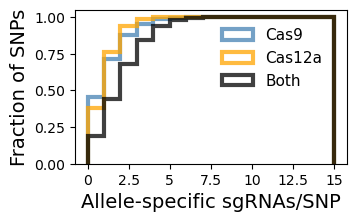

In [72]:
plt.figure(figsize=(3.5,2))
plt.hist(coverage_dist_cas9, bins=range(0,16), cumulative=True, histtype='step', density=True, lw=3, alpha=0.75, color='steelblue')
plt.hist(coverage_dist_cas12, bins=range(0,16), cumulative=True, histtype='step', density=True, lw=3, alpha=0.75, color='orange')
plt.hist(coverage_dist_combined, bins=range(0,16), cumulative=True, histtype='step', density=True, lw=3, alpha=0.75, color="k")

plt.legend(['Cas9', 'Cas12a', 'Both'], loc = (0.52,0.45), frameon=False, fontsize=11)



plt.xlabel('Allele-specific sgRNAs/SNP', fontsize=14)
plt.ylabel('Fraction of SNPs', fontsize=14)
plt.xticks([0,2.5,5,7.5,10,12.5,15], ['0','2.5','5','7.5','10','12.5','15'])

plt.savefig('./figures/sgRNA_per_SNP.svg', format='svg', dpi=300, bbox_inches='tight')

## Genome editing results

### Figure 1D

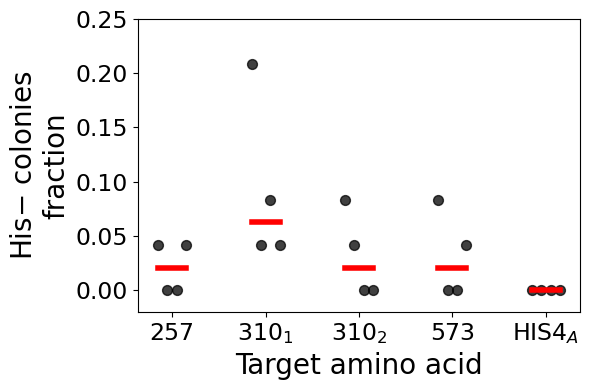

In [74]:
plt.figure(figsize=(6,4))

sgRNA_257 = [1,0,0,1]
sgRNA_310_1 = [5,1,2,1]
sgRNA_310_2 = [2,1,0,0]
sgRNA_573 = [2,0,0,1]
sgRNA_310_A = [0,0,0,0]

plt.scatter([1+x for x in np.linspace(-0.15, 0.15, len(sgRNA_257))], [x/24 for x in sgRNA_257], color='k', alpha=0.75, s=50)
plt.plot([0.85,1.15],[np.median([x/24 for x in sgRNA_257]), np.median([x/24 for x in sgRNA_257])], color='r', lw=4)

plt.scatter([2+x for x in np.linspace(-0.15, 0.15, len(sgRNA_310_1))], [x/24 for x in sgRNA_310_1], color='k', alpha=0.75, s=50)
plt.plot([1.85,2.15],[np.median([x/24 for x in sgRNA_310_1]), np.median([x/24 for x in sgRNA_310_1])], color='r', lw=4)

plt.scatter([3+x for x in np.linspace(-0.15, 0.15, len(sgRNA_310_2))], [x/24 for x in sgRNA_310_2], color='k', alpha=0.75, s=50)
plt.plot([2.85,3.15],[np.median([x/24 for x in sgRNA_310_2]), np.median([x/24 for x in sgRNA_310_2])], color='r', lw=4)

plt.scatter([4+x for x in np.linspace(-0.15, 0.15, len(sgRNA_573))], [x/24 for x in sgRNA_573], color='k', alpha=0.75, s=50)
plt.plot([3.85,4.15],[np.median([x/24 for x in sgRNA_573]), np.median([x/24 for x in sgRNA_573])], color='r', lw=4)

plt.scatter([5+x for x in np.linspace(-0.15, 0.15, len(sgRNA_310_A))], [x/24 for x in sgRNA_310_A], color='k', alpha=0.75, s=50)
plt.plot([4.85,5.15],[np.median([x/24 for x in sgRNA_310_A]), np.median([x/24 for x in sgRNA_310_A])], color='r', lw=4)

plt.ylim(-0.02,0.25)

plt.xticks([1,2,3,4,5], ['257', r'310$_{1}$', '310$_{2}$', '573', 'HIS4$_{A}$'], fontsize=17)
plt.yticks(fontsize=17)


plt.xlabel('Target amino acid', fontsize=20)
plt.ylabel('His${-}$ colonies\nfraction', fontsize=20)
plt.tight_layout()





plt.savefig('./figures/his_auxotroph_rate.svg', format='svg', dpi=300)

### Figure S1

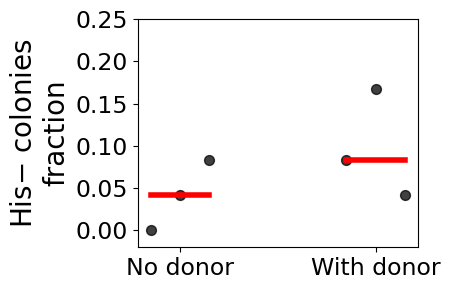

In [76]:
plt.figure(figsize=(4.5,3))

no_donor = [0,1,2]
with_donor = [2,4,1]


plt.scatter([1+x for x in np.linspace(-0.15, 0.15, len(no_donor))], [x/24 for x in no_donor], color='k', alpha=0.75, s=50)
plt.plot([0.85,1.15],[np.median([x/24 for x in no_donor]), np.median([x/24 for x in no_donor])], color='r', lw=4)

plt.scatter([2+x for x in np.linspace(-0.15, 0.15, len(with_donor))], [x/24 for x in with_donor], color='k', alpha=0.75, s=50)
plt.plot([1.85,2.15],[np.median([x/24 for x in with_donor]), np.median([x/24 for x in with_donor])], color='r', lw=4)

plt.ylim(-0.02,0.25)

plt.xticks([1,2], ['No donor', r'With donor'], fontsize=17)
plt.yticks(fontsize=17)


plt.ylabel('His${-}$ colonies\nfraction', fontsize=20)
plt.tight_layout()





plt.savefig('./figures/donor_dna.svg', format='svg', dpi=300)
plt.savefig('./figures/donor_dna.png', format='png', dpi=300)

### Figure 4B

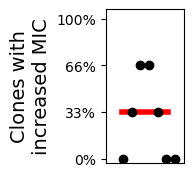

In [77]:
plt.figure(figsize=(1,2))

ax1 = plt.scatter([0.1,0.2,0.3,0.4,0.5,0.6, 0.7], [0,1,2,2,1,0,0], color='k', zorder=9)

plt.xticks([],[])
plt.yticks([0,1,2,3], ['0%', '33%', '66%', '100%'])
plt.ylabel('Clones with\nincreased MIC', fontsize=14)

plt.axhline(np.median([0,1,2,3,1,0,0]), 0.2,0.8, color='red', lw=4)

plt.ylim(-0.1, 3.2)
plt.xlim(-0.1,0.8)

plt.savefig('./figures/KSR1_MIC_fractions.svg', format='svg', dpi=300, bbox_inches='tight')

## WGS results

### Allele frequency graphs from pileups

In [78]:
snp_HIS4_region_dict = {}


SNP_count=0
with open('./ref_genome_seq/C_albicans_SC5314_haplotype_variations.tab', 'r') as source:
    for line in source:
        if line.startswith('Hap A')==False:
            line_info=line.split('\t')
            chr_A = line_info[0]
            chr_B = line_info[3]

            position_A = int(line_info[2]) - 1

            if chr_A.strip('Ca22chr').strip('A_C_albicans_SC5314') != chr_B.strip('Ca22chr').strip('B_C_albicans_SC5314'):
                print(line)
                # all heterozygous sites are matched in terms of chromosome

            if line_info[6] == '1 nt subs' and line_info[0]=='Ca22chr4A_C_albicans_SC5314' and position_A in range(12266,35767):
                SNP_count+=1

                nt_allele_A = line_info[7][1]
                nt_allele_B = line_info[8][1]

                snp_HIS4_region_dict[position_A] = [nt_allele_A, nt_allele_B]

                #print(chr_A, position_A, nt_allele_A, nt_allele_B)
                    

In [79]:
file_list = os.listdir('./pileups/')

In [83]:
HIS4_pileups = [x for x in file_list if '.HIS4' in x]
HIS4_pileups

['HIS4_AA_1.HIS4.pileup',
 'HIS4_AA_2.HIS4.pileup',
 'HIS4_AA_3.HIS4.pileup',
 'HIS4_AA_4.HIS4.pileup',
 'HIS4_BB_1.HIS4.pileup',
 'HIS4_BB_2.HIS4.pileup',
 'HIS4_BB_3.HIS4.pileup',
 'HIS4_BB_4.HIS4.pileup']

In [84]:
chr_ID_to_genbank = {'Ca22chr1A_C_albicans_SC5314':'NC_032089.1',
                     'Ca22chr2A_C_albicans_SC5314':'NC_032090.1',
                     'Ca22chr3A_C_albicans_SC5314':'NC_032091.1',
                     'Ca22chr4A_C_albicans_SC5314':'NC_032092.1',
                     'Ca22chr5A_C_albicans_SC5314':'NC_032093.1',
                     'Ca22chr6A_C_albicans_SC5314':'NC_032094.1',
                     'Ca22chr7A_C_albicans_SC5314':'NC_032095.1',
                     'Ca22chrRA_C_albicans_SC5314':'NC_032096.1'}

genbank_to_chr_no = {'NC_032089.1':'Chr1',
                     'NC_032090.1':'Chr2',
                     'NC_032091.1':'Chr3',
                     'NC_032092.1':'Chr4',
                     'NC_032093.1':'Chr5',
                     'NC_032094.1':'Chr6',
                     'NC_032095.1':'Chr7',
                     'NC_032096.1':'ChrR'}

# dictionaries to convert between different Chr names

In [85]:
def get_pileup_df(file):
    # import and format fata from samtools pileup

    pileup_df= pd.read_csv('./pileups/'+file, sep='\t', header=None, names=['chr', 'pos', 'ref_allele', 'depth', 'pileup', 'quality'])
    pileup_df['pileup'] = pileup_df['pileup'].str.upper()

    pileup_df['nt_A_count'] = pileup_df['pileup'].str.count('A')
    pileup_df['nt_T_count'] = pileup_df['pileup'].str.count('T')
    pileup_df['nt_G_count'] = pileup_df['pileup'].str.count('G')
    pileup_df['nt_C_count'] = pileup_df['pileup'].str.count('C')
    
    pileup_df['nt_A_freq'] = pileup_df['nt_A_count']/pileup_df['depth']
    pileup_df['nt_T_freq'] = pileup_df['nt_T_count']/pileup_df['depth']
    pileup_df['nt_G_freq'] = pileup_df['nt_G_count']/pileup_df['depth']
    pileup_df['nt_C_freq'] = pileup_df['nt_C_count']/pileup_df['depth']
    
    
    for pos in list(pileup_df.index):
        ref_nt = (pileup_df.at[pos, 'ref_allele']).upper()
        ref_count = (pileup_df.at[pos, 'pileup']).count('.')+(pileup_df.at[pos, 'pileup']).count(',')
    
        if ref_nt == 'A':
            pileup_df.at[pos, 'nt_A_count'] = ref_count
            pileup_df.at[pos, 'nt_A_freq'] = pileup_df.at[pos, 'nt_A_count']/pileup_df.at[pos, 'depth']
            pileup_df.at[pos, 'ref_nt_freq'] =pileup_df.at[pos, 'nt_A_count']/pileup_df.at[pos, 'depth']
    
        if ref_nt == 'T':
            pileup_df.at[pos, 'nt_T_count'] = ref_count
            pileup_df.at[pos, 'nt_T_freq'] = pileup_df.at[pos, 'nt_T_count']/pileup_df.at[pos, 'depth']
            pileup_df.at[pos, 'ref_nt_freq'] =pileup_df.at[pos, 'nt_T_count']/pileup_df.at[pos, 'depth']
    
        
        if ref_nt == 'G':
            pileup_df.at[pos, 'nt_G_count'] = ref_count
            pileup_df.at[pos, 'nt_G_freq'] = pileup_df.at[pos, 'nt_G_count']/pileup_df.at[pos, 'depth']
            pileup_df.at[pos, 'ref_nt_freq'] =pileup_df.at[pos, 'nt_G_count']/pileup_df.at[pos, 'depth']
        
        if ref_nt == 'C':
            pileup_df.at[pos, 'nt_C_count'] = ref_count
            pileup_df.at[pos, 'nt_C_freq'] = pileup_df.at[pos, 'nt_C_count']/pileup_df.at[pos, 'depth']
            pileup_df.at[pos, 'ref_nt_freq'] =pileup_df.at[pos, 'nt_C_count']/pileup_df.at[pos, 'depth']

    pileup_df['chr_name'] = pileup_df['chr'].map(genbank_to_chr_no)
            
    return pileup_df

get_pileup_df(HIS4_pileups[2])
    

,chr,pos,ref_allele,depth,pileup,quality,nt_A_count,nt_T_count,nt_G_count,nt_C_count,nt_A_freq,nt_T_freq,nt_G_freq,nt_C_freq,ref_nt_freq,chr_name
0,NC_032092.1,9766,A,50,",...,,...,...,.....,,.,.,,.,....,,,..,.*..,,.,...",FHNIJIOG>IKAJHQKKPOSESJIGABIKOI6DFIG0HS1MAIBNL...,49,0,0,0,0.98,0.0,0.0,0.0,0.98,Chr4
1,NC_032092.1,9767,A,50,",...,,...,...,.....,,.,.,,.,....,,,..,.*..,,.,...",FGLMIERG?JMAHHSJHJJKDQHJIBDEJIO6DDLG=GI1QBS@LL...,49,0,0,0,0.98,0.0,0.0,0.0,0.98,Chr4
2,NC_032092.1,9768,C,50,",...,,...,...,.....,,.,.,,.,....,,,..,....,,.,...",HDPJJFLFBEK?HEKKJISLCILHI@@FILS4DEMFCIG1S@M@IK...,0,0,0,50,0.00,0.0,0.0,1.0,1.00,Chr4
3,NC_032092.1,9769,G,50,",...,,...,...,.....,,.,.,,.,....,,,..,....,,.,...",H?S2NGPC?GJ<FHFHGILIDKKIHB?GIHL2DDKCHHF1L>I@KI...,0,0,50,0,0.00,0.0,1.0,0.0,1.00,Chr4
4,NC_032092.1,9770,G,50,",...,,...,...,.....,,.,.,,.,....,,,..,....,,.,...",I>I2HFQC=GH<DIESHHKLAMJHGBHHJIQ4FHJDNJH5L=M@JN...,0,0,50,0,0.00,0.0,1.0,0.0,1.00,Chr4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25996,NC_032092.1,35762,A,50,"....,.,..,,...,.,.,..,,,.,.,,.,..,,.,,.,..,,.,...",MKK@ISELDSESJLQIMN:IORDS9GASLFSJQS@KSSJSGI?SNL...,50,0,0,0,1.00,0.0,0.0,0.0,1.00,Chr4
25997,NC_032092.1,35763,g,50,"....,.,..,,...,.,.,..,,,.,.,,.,..,,.,,.,..,,.,...",JKPBENEM@LFJPJSHJS:KSS?S8G?MOEIOSSAJSSNQFI=JSG...,0,0,50,0,0.00,0.0,1.0,0.0,1.00,Chr4
25998,NC_032092.1,35764,t,50,"....,.,..,,...,.,.,..,,,.,.,,.,..,,.,,.,..,,.,...",SKNCDMGP@KQIJKOHJRJHMS=J7E>KIDSRHL<NOOSIJH=SND...,0,50,0,0,0.00,1.0,0.0,0.0,1.00,Chr4
25999,NC_032092.1,35765,a,50,"....,.,..,,...,.,.,..,,,.,.,,.,..,,.,,.,..,,.,...",SKSBESKNASNNSKSGLSSMOS>L6S>SHDSIJO<MKSOMFK@NKD...,50,0,0,0,1.00,0.0,0.0,0.0,1.00,Chr4


In [86]:
HIS4_pileups_df_dict = {} 

for x in HIS4_pileups:
    HIS4_pileups_df_dict[x]= get_pileup_df(x)

/tmp/ipykernel_210/1730992195.py:29: RuntimeWarning: invalid value encountered in scalar divide
  pileup_df.at[pos, 'nt_T_freq'] = pileup_df.at[pos, 'nt_T_count']/pileup_df.at[pos, 'depth']
/tmp/ipykernel_210/1730992195.py:30: RuntimeWarning: invalid value encountered in scalar divide
  pileup_df.at[pos, 'ref_nt_freq'] =pileup_df.at[pos, 'nt_T_count']/pileup_df.at[pos, 'depth']
/tmp/ipykernel_210/1730992195.py:40: RuntimeWarning: invalid value encountered in scalar divide
  pileup_df.at[pos, 'nt_C_freq'] = pileup_df.at[pos, 'nt_C_count']/pileup_df.at[pos, 'depth']
/tmp/ipykernel_210/1730992195.py:41: RuntimeWarning: invalid value encountered in scalar divide
  pileup_df.at[pos, 'ref_nt_freq'] =pileup_df.at[pos, 'nt_C_count']/pileup_df.at[pos, 'depth']


In [87]:
HIS4_pileups

['HIS4_AA_1.HIS4.pileup',
 'HIS4_AA_2.HIS4.pileup',
 'HIS4_AA_3.HIS4.pileup',
 'HIS4_AA_4.HIS4.pileup',
 'HIS4_BB_1.HIS4.pileup',
 'HIS4_BB_2.HIS4.pileup',
 'HIS4_BB_3.HIS4.pileup',
 'HIS4_BB_4.HIS4.pileup']

### Figure 2

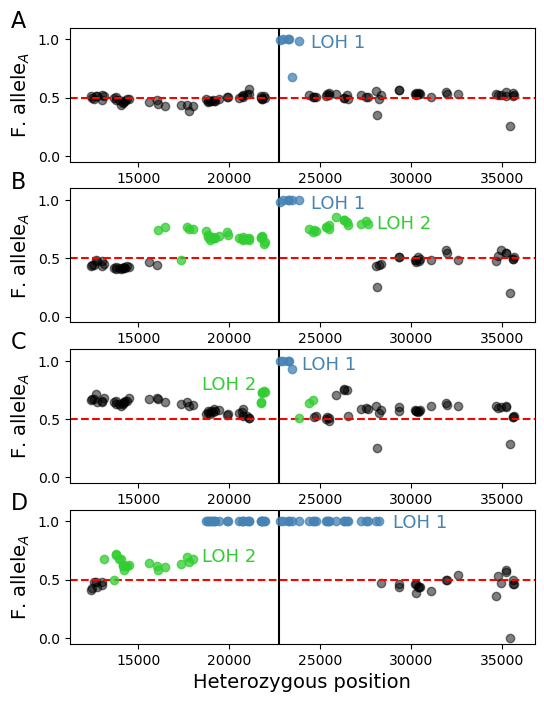

In [100]:
plt.figure(figsize=(6,8))



###########

ax1 = plt.subplot(411)


AA_1_pileup_df = HIS4_pileups_df_dict['HIS4_AA_1.HIS4.pileup']
AA_1_snp_pos_filter_pileup = AA_1_pileup_df['pos'].isin(list(snp_HIS4_region_dict.keys()))

AA_1_LOH_1_pos = (AA_1_pileup_df['pos'] >=22766) & (AA_1_pileup_df['pos'] <= 23841)

plt.scatter(AA_1_pileup_df[AA_1_LOH_1_pos&AA_1_snp_pos_filter_pileup]['pos'], AA_1_pileup_df[AA_1_LOH_1_pos&AA_1_snp_pos_filter_pileup]['ref_nt_freq'], zorder=9, color='steelblue', alpha=0.75)
plt.scatter(AA_1_pileup_df[(AA_1_snp_pos_filter_pileup)&~(AA_1_LOH_1_pos)]['pos'], AA_1_pileup_df[(AA_1_snp_pos_filter_pileup)&~(AA_1_LOH_1_pos)]['ref_nt_freq'], color='k', alpha=0.5)

plt.ylim(-0.05,1.1)

plt.axvline(22751, color='k', linestyle='-')
plt.axhline(0.5, color='red', linestyle='--')

plt.text(24500, 0.925, 'LOH 1', fontsize=13, color='steelblue')


plt.ylabel(r'F. allele$_{A}$', fontsize=14)
#plt.title('HIS1_A/HIS4_A 1', fontsize=14)

plt.text(8000, 1.1, 'A',fontsize =16)

####################################
ax1 = plt.subplot(412)

AA_2_pileup_df = HIS4_pileups_df_dict['HIS4_AA_2.HIS4.pileup']
AA_2_snp_pos_filter_pileup = AA_2_pileup_df['pos'].isin(list(snp_HIS4_region_dict.keys()))

AA_2_LOH_1_pos = (AA_2_pileup_df['pos'] >=22766) & (AA_2_pileup_df['pos'] <= 23841)
AA_2_LOH_2_pos = (AA_2_pileup_df['pos'] >=16107) & (AA_2_pileup_df['pos'] <= 27616)

plt.scatter(AA_2_pileup_df[AA_2_LOH_1_pos&AA_2_snp_pos_filter_pileup]['pos'], AA_2_pileup_df[AA_2_LOH_1_pos&AA_2_snp_pos_filter_pileup]['ref_nt_freq'], 
            zorder=9, color='steelblue', alpha=0.75)
plt.scatter(AA_2_pileup_df[AA_2_LOH_2_pos&~AA_2_LOH_1_pos&AA_2_snp_pos_filter_pileup]['pos'], AA_2_pileup_df[AA_2_LOH_2_pos&~AA_2_LOH_1_pos&AA_2_snp_pos_filter_pileup]['ref_nt_freq'], 
            zorder=9, color='limegreen', alpha=0.75)
plt.scatter(AA_2_pileup_df[(AA_2_snp_pos_filter_pileup)&~(AA_2_LOH_1_pos)&~AA_2_LOH_2_pos]['pos'], AA_2_pileup_df[(AA_2_snp_pos_filter_pileup)&~(AA_2_LOH_1_pos)&~AA_2_LOH_2_pos]['ref_nt_freq'],
            color='k', alpha=0.5)


plt.ylim(-0.05,1.1)
plt.axvline(22751, color='k', linestyle='-')
plt.axhline(0.5, color='red', linestyle='--')

plt.text(24500, 0.925, 'LOH 1', fontsize=13, color='steelblue')
plt.text(28100, 0.75, 'LOH 2', fontsize=13, color='limegreen')


plt.ylabel(r'F. allele$_{A}$', fontsize=14)
plt.text(8000, 1.1, 'B',fontsize =16)


############################################################

ax1 = plt.subplot(413)


AA_3_pileup_df = HIS4_pileups_df_dict['HIS4_AA_3.HIS4.pileup']
AA_3_snp_pos_filter_pileup = AA_3_pileup_df['pos'].isin(list(snp_HIS4_region_dict.keys()))


AA_3_LOH_1_pos = (AA_3_pileup_df['pos'] >=22766) & (AA_3_pileup_df['pos'] <= 23429)
AA_3_LOH_2_pos = (AA_3_pileup_df['pos'] >=21712) & (AA_3_pileup_df['pos'] <= 24576)

plt.scatter(AA_3_pileup_df[AA_3_LOH_1_pos&AA_3_snp_pos_filter_pileup]['pos'], AA_3_pileup_df[AA_3_LOH_1_pos&AA_3_snp_pos_filter_pileup]['ref_nt_freq'], 
            zorder=9, color='steelblue', alpha=0.75)
plt.scatter(AA_3_pileup_df[AA_3_LOH_2_pos&~AA_3_LOH_1_pos&AA_3_snp_pos_filter_pileup]['pos'], AA_3_pileup_df[AA_3_LOH_2_pos&~AA_3_LOH_1_pos&AA_3_snp_pos_filter_pileup]['ref_nt_freq'], 
            zorder=9, color='limegreen', alpha=0.75)
plt.scatter(AA_3_pileup_df[(AA_3_snp_pos_filter_pileup)&~(AA_3_LOH_1_pos)&~AA_3_LOH_2_pos]['pos'], AA_3_pileup_df[(AA_3_snp_pos_filter_pileup)&~(AA_3_LOH_1_pos)&~AA_3_LOH_2_pos]['ref_nt_freq'],
            color='k', alpha=0.5)


plt.ylim(-0.05,1.1)
plt.axvline(22751, color='k', linestyle='-')
plt.axhline(0.5, color='red', linestyle='--')


plt.text(24000, 0.925, 'LOH 1', fontsize=13, color='steelblue')
plt.text(18500, 0.75, 'LOH 2', fontsize=13, color='limegreen')


plt.ylabel(r'F. allele$_{A}$', fontsize=14)
plt.text(8000, 1.1, 'C',fontsize =16)


##################################################################################################

ax1 = plt.subplot(414)
AA_4_pileup_df = HIS4_pileups_df_dict['HIS4_AA_4.HIS4.pileup']
AA_4_snp_pos_filter_pileup = AA_4_pileup_df['pos'].isin(list(snp_HIS4_region_dict.keys()))


AA_4_LOH_1_pos = (AA_4_pileup_df['pos'] >=18711) & (AA_4_pileup_df['pos'] <= 28215)
AA_4_LOH_2_pos = (AA_4_pileup_df['pos'] >=13124) & (AA_4_pileup_df['pos'] <= 28215)

plt.scatter(AA_4_pileup_df[AA_4_LOH_1_pos&AA_4_snp_pos_filter_pileup]['pos'], AA_4_pileup_df[AA_4_LOH_1_pos&AA_4_snp_pos_filter_pileup]['ref_nt_freq'], 
            zorder=9, color='steelblue', alpha=0.75)
plt.scatter(AA_4_pileup_df[AA_4_LOH_2_pos&~AA_4_LOH_1_pos&AA_4_snp_pos_filter_pileup]['pos'], AA_4_pileup_df[AA_4_LOH_2_pos&~AA_4_LOH_1_pos&AA_4_snp_pos_filter_pileup]['ref_nt_freq'], 
            zorder=9, color='limegreen', alpha=0.75)
plt.scatter(AA_4_pileup_df[(AA_4_snp_pos_filter_pileup)&~(AA_4_LOH_1_pos)&~AA_4_LOH_2_pos]['pos'], AA_4_pileup_df[(AA_4_snp_pos_filter_pileup)&~(AA_4_LOH_1_pos)&~AA_4_LOH_2_pos]['ref_nt_freq'],
            color='k', alpha=0.5)

plt.ylim(-0.05,1.1)
plt.axvline(22751, color='k', linestyle='-')
plt.axhline(0.5, color='red', linestyle='--')
plt.ylabel(r'F. allele$_{A}$', fontsize=14)
plt.text(8000, 1.1, 'D',fontsize =16)

plt.text(29000, 0.95, 'LOH 1', fontsize=13, color='steelblue')
plt.text(18500, 0.65, 'LOH 2', fontsize=13, color='limegreen')


plt.xlabel('Heterozygous position', fontsize=14)


plt.savefig('./figures/LOH_tracts_AA.svg', format='svg', dpi=300)

In [94]:
AA_1_pileup_df[AA_1_pileup_df['pos'].isin([x for x in list(snp_HIS4_region_dict.keys()) if x>21000 and x <25000])]
#AA_1_LOH_1 covers from 22766 to 23841 = 1075

,chr,pos,ref_allele,depth,pileup,quality,nt_A_count,nt_T_count,nt_G_count,nt_C_count,nt_A_freq,nt_T_freq,nt_G_freq,nt_C_freq,ref_nt_freq,chr_name
11289,NC_032092.1,21055,A,115,".G..G.G...GG.,,G.GG.,GGGGGG.,G.G,..GGGGGGG.G.....",F/LHCJJAHNBAGJDAI=1IJJDELLNM>EH7HIGIICH.6;L=G2...,66,0,49,0,0.573913,0.000000,0.426087,0.000000,0.573913,Chr4
11308,NC_032092.1,21074,G,120,".A.AAA.A...AA.,,A.AA.,AAAAAA.,A.A,..,AAAAAAA.A...",FEJ<E@FJS2IOCOKDKHGGFCSHGNJGL@SHBC/P2JMNKFKGJ@...,56,0,64,0,0.466667,0.000000,0.533333,0.000000,0.533333,Chr4
11946,NC_032092.1,21712,A,127,".T.TTT.T...TTTTT,T.TT.,TTTTT.,T,..,TTTTT...TTT...",K4PHHINLNSSOMNNJHOQKLHBOSMFISOLSKL=FKL>ENOEGKK...,65,62,0,0,0.511811,0.488189,0.000000,0.000000,0.511811,Chr4
11991,NC_032092.1,21757,A,123,".G.GGG.G...GGGGG,G.GG.,GGGGG.,G,.,GGGGG...GGG....",?SHLISPCJ4>GHSKKFLHBKBBSSGCKCLLSC7JFOOGDH=SIMN...,61,0,62,0,0.495935,0.000000,0.504065,0.000000,0.495935,Chr4
12021,NC_032092.1,21787,A,125,".T.TTT.T...TTTTT,T.TT.,TTTTT.,T,..TTTTT...TTTT...",;OJJGRA@KJJ?BMSLKSDLM=?MMCH/OSHO@8MBSIAJG7<L@E...,61,64,0,0,0.488000,0.512000,0.000000,0.000000,0.488000,Chr4
12039,NC_032092.1,21805,A,124,".C.CCC.C...CCCCCC.CC.,CCCCC.,C,.,CCCCC...CCCC....",HFOPSILF1POEQCSSRKNJH@ISN<BNSSSSA.GEN=OKG7JENI...,61,0,0,63,0.491935,0.000000,0.000000,0.508065,0.491935,Chr4
12159,NC_032092.1,21925,A,130,".G.GGG.G...GGGGG,G.GG.,GGGGG.,G,..,GGGGG...GGG...",IMLLINBPGGFI<SLQMNRMRG3SKCMSQ;SIHN5SJRG@MD:6SK...,67,0,63,0,0.515385,0.000000,0.484615,0.000000,0.515385,Chr4
12210,NC_032092.1,21976,C,128,".G.GGG.G...GGGGG,G.GG.,GGGGG.,G,..,GGGGG.G..GG...",R;OSHHFSKLHILSRJLSDKJM=LKFKPECK@NK4MSSSH?NM?>G...,0,0,63,64,0.000000,0.000000,0.492188,0.500000,0.500000,Chr4
13000,NC_032092.1,22766,A,121,".,..,......,.,,...,.,,,.,,.,,,..,,.,....G,,......",FJMCQ>@C4:IOCSKIJLMGJPNBCAE?NMD?DSJG8HNI/KKACH...,120,0,1,0,0.991736,0.000000,0.008264,0.000000,0.991736,Chr4
13160,NC_032092.1,22926,G,118,".,.......,.,,...,.,,,.,,.,,,..,.,....,,..,,.,....",JQNMGPGB4SMJSGHAKHFSLINHI>IMGLPJI?.GOSLFHSOHJI...,0,0,118,0,0.000000,0.000000,1.000000,0.000000,1.000000,Chr4


In [95]:
AA_2_pileup_df[AA_2_pileup_df['pos'].isin([x for x in list(snp_HIS4_region_dict.keys()) if x>21000 and x <25000])]
#AA_2_LOH_1 covers from 22766 to 23841 = 1075

,chr,pos,ref_allele,depth,pileup,quality,nt_A_count,nt_T_count,nt_G_count,nt_C_count,nt_A_freq,nt_T_freq,nt_G_freq,nt_C_freq,ref_nt_freq,chr_name
11289,NC_032092.1,21055,A,49,"..G....G,,G,G,..,GG,G..,,....GGGG..,...G,GG,G.G.,",BG.FESG?HH:S;GHAICFF0HDKGJAHLGFG8=IIL.G;@E5S@?=HE,33,0,16,0,0.673469,0.000000,0.326531,0.000000,0.673469,Chr4
11308,NC_032092.1,21074,G,52,"..A....A,,A,A,..A.,AA,A..,,....AAAA..,...A,AAA...",AQ:NEKFE=GAQ>DHJ5?LE<>MFBG>S@GSHHG2KKEJKHHSMS?...,18,0,34,0,0.346154,0.000000,0.653846,0.000000,0.653846,Chr4
11946,NC_032092.1,21712,A,50,".,..T,,T,T,..T.,TT,.,,...TTTT..,...T,TTT,T.T.,...",AFSSNBODKOQNJ9BSQLKDSHORSS?SPKHBDKLMSSHGSGIORO...,34,16,0,0,0.680000,0.320000,0.000000,0.000000,0.680000,Chr4
11991,NC_032092.1,21757,A,52,".,..G,,G,G,..G.,GG,G.,,...GGGG..,...G,GGG,G.G....",7OHILEL=SMS:F5:MOSKJ8KJQHSSMSLGM?ACCSKSFDL?CQL...,35,0,17,0,0.673077,0.000000,0.326923,0.000000,0.673077,Chr4
12021,NC_032092.1,21787,A,53,".,..T,,T,T,..T.,TT,T.,,...TTTT..,...T,TTT,T.T....",/SH@ONS:PBIMG72SSSGD2HSMLNJILSLJ?:AIQSSE=K<HSF...,36,17,0,0,0.679245,0.320755,0.000000,0.000000,0.679245,Chr4
12039,NC_032092.1,21805,A,52,".,..C,,C,C,..C.,CC,.,,...CCCC..,...C,CCC,C.C.,...",?SQSOOSCS<HPP?BMMQF@JSORPFPOSSN;KIIKSPAFLGMOSS...,36,0,0,16,0.692308,0.000000,0.000000,0.307692,0.692308,Chr4
12159,NC_032092.1,21925,A,53,".,.GGG,G,G,..G.,GG,GG,,...GGGG..,...G,GGG,G.,....",9HRBPLR=LFLKK67JININHMLMLONLMOKRBIJONOKG<G<AMG...,33,0,20,0,0.622642,0.000000,0.377358,0.000000,0.622642,Chr4
12210,NC_032092.1,21976,C,50,".,.GGG,G,G,..G.,GG,GG,,...GGG..,...,GGG,G.,.G....",:QKGK;K?KLLMJ=:CINFOKKMSLLJHSRM:SQKSSD@GADSI@D...,0,0,18,32,0.000000,0.000000,0.360000,0.640000,0.640000,Chr4
13000,NC_032092.1,22766,A,53,".,..,,.,,.G..,,,,.,,..,..,.,...,,,.,...,.,,.,,...",:SJ>NIHKI>.26MEJMDRS<JMGLSEF:I9MJNCSFDD9>OPDO4...,52,0,1,0,0.981132,0.000000,0.018868,0.000000,0.981132,Chr4
13160,NC_032092.1,22926,G,56,".,..,,.,,....,,,,.,,.,.,.,...,,,.,...,.,,.,,,....",AMKIFOGQPM?9BQKQMGPJ5SHJOJADAMKLCSJIJN>SKFP<PE...,0,0,56,0,0.000000,0.000000,1.000000,0.000000,1.000000,Chr4


In [96]:
AA_2_pileup_df[AA_2_pileup_df['pos'].isin([x for x in list(snp_HIS4_region_dict.keys()) if x>26000 and x <29000])]
#AA_2_LOH_2 covers from 16107 to 27616 = 11509

,chr,pos,ref_allele,depth,pileup,quality,nt_A_count,nt_T_count,nt_G_count,nt_C_count,nt_A_freq,nt_T_freq,nt_G_freq,nt_C_freq,ref_nt_freq,chr_name
16535,NC_032092.1,26301,A,53,",.,G...G,,.,,,G.,G..G.,.,,..,.,.,GG.....,,,,G....",SSMIRB>ASHJDRPEGSMKHKKSJLFLHRRJ=LJCLJEPHGS9HHQ...,44,0,9,0,0.830189,0.000000,0.169811,0.000000,0.830189,Chr4
16544,NC_032092.1,26310,G,53,",.,C...C,,.,,,C.,C.C.,.,,..,.,.,CC.....,,,,,C....",S:KMS<?AISH<MSGDKSISNN9LS=?OLM>JN4KIJ=<D:C;NKS...,0,0,44,9,0.000000,0.000000,0.830189,0.169811,0.830189,Chr4
16713,NC_032092.1,26479,G,53,",.,A...A,,.,,,A.,.A.,.,,..,..,AA.....,,,,,A.,....",MLJHGBHGLNCCPEEIKBJJKHJK.ESCAINHSOSL=H2K@EMOD:...,10,0,43,0,0.188679,0.000000,0.811321,0.000000,0.811321,Chr4
16729,NC_032092.1,26495,C,52,",.,T...T,,.,,,T.,T.T.,.,,..,..,TT.....,,,T.,.....",KKIM@<@SGM=CLE;D=8>M5@>OI<IPL;NBFHMFEOQ<IHIFHN...,0,11,0,41,0.000000,0.211538,0.000000,0.788462,0.788462,Chr4
17462,NC_032092.1,27228,g,44,",.,A..,.,,,A.,A.A.,.,,.,..,A..,,,,A.,..A,.AA",KHK@I@GBHLS>@PC@JBM9MJDOB?IKMIFIKNJCGSI?J.KS,9,0,35,0,0.204545,0.000000,0.795455,0.000000,0.795455,Chr4
17740,NC_032092.1,27506,C,45,",.,T..,.,,T.,.T.,.,,.,..,TT...,,,,T.,..,TT..,",ISIJMA@RJICCH??LJ@8KHHOCESLSGSIKDCIE>SQF<EHG@,0,8,0,37,0.000000,0.177778,0.000000,0.822222,0.822222,Chr4
17850,NC_032092.1,27616,T,44,",.,G.,.,,G.,G.G.,.,.,..,GG...,,,,G.,..,GG..,",PNNGABIIHAFH>A<LNAJJJLBKSFN;RJPGGJEBNQJHJCLH,0,35,9,0,0.000000,0.795455,0.204545,0.000000,0.795455,Chr4
18285,NC_032092.1,28051,T,44,"A.A.A.AAA.A,A.A.,AAA.AAAA...,AAA.,.AAA...AAA",EI8GKIMKMIHKK:JLJHLIMBGK3IHKN>@MP>HG?IGJSKHS,25,19,0,0,0.568182,0.431818,0.000000,0.000000,0.431818,Chr4
18324,NC_032092.1,28090,t,4,",+1CCC",ADSM,0,1,0,3,0.000000,0.250000,0.000000,0.750000,0.250000,Chr4
18449,NC_032092.1,28215,A,43,"G.G.G.GGG.,G.G.,GGG.GGGG...,GGG.,GGG.,.GGG.",IFNAKIJLKHPL>L>S<IKJFNRNBBMMFOL0DNNID:IJMKL,19,0,24,0,0.441860,0.000000,0.558140,0.000000,0.441860,Chr4


In [97]:
AA_2_pileup_df[AA_2_pileup_df['pos'].isin([x for x in list(snp_HIS4_region_dict.keys()) if x>15000 and x <18000])]


,chr,pos,ref_allele,depth,pileup,quality,nt_A_count,nt_T_count,nt_G_count,nt_C_count,nt_A_freq,nt_T_freq,nt_G_freq,nt_C_freq,ref_nt_freq,chr_name
5830,NC_032092.1,15596,A,53,"GG,...GG..G.,GGGGGG..GG..,.,,GGGGGG,GGG.G,G,,G...",<7KOGKSSSK0LNEL7GG9GS@6JEM;DCHOMEH4JH9H?FIKBCH...,25,0,28,0,0.471698,0.000000,0.528302,0.000000,0.471698,Chr4
6264,NC_032092.1,16030,C,45,"TT,...T.TTTTT.TT...,,TTTT*T,TTT.T,,,T,,T..TTT",;KKIEB5JP7GIHE@>AHL<C;HEO8J<SGJBQKS.PLNENA4BK,0,24,0,20,0.000000,0.533333,0.000000,0.444444,0.444444,Chr4
6341,NC_032092.1,16107,C,43,".T,......T.TTT,....,T.,,TT,.T,.,,.,,T..,,,T",7FIQJL><@CKOQG7<OGQ<DS.KPB7IDM<K8HF=@D2?<H;,0,11,0,32,0.000000,0.255814,0.000000,0.744186,0.744186,Chr4
6728,NC_032092.1,16494,t,43,".,.....-1.C.CCC.,....,C.,,C,.C,.,.,,C..,,,CC,",HSRFL@IS3JI>9O:JLLSFFMS>4J4EGP?:OLHPBFKS<AG,0,33,0,10,0.000000,0.767442,0.000000,0.232558,0.767442,Chr4
7592,NC_032092.1,17358,T,45,"C,..C.CCCCC.CC...,CCCCC,CCC.,C,,..CCCC,C..,,,",?OSLDJSBJSGKCIIABLPAPNBNL=SNA=SS>DNSSSDFIKLCJ,0,22,0,23,0.000000,0.488889,0.000000,0.511111,0.488889,Chr4
7908,NC_032092.1,17674,T,43,".,..GGG.,....,G,,G,.C,.,.G..,,GG,G.+1.,,,,...",8PHLKKHJOESDBLPCK?SL.M9=S:S/OO@=P;CQSFO?:JO,0,33,9,1,0.000000,0.767442,0.209302,0.023256,0.767442,Chr4
8021,NC_032092.1,17787,C,44,".,..AAAA.,....A,,A,.A,.,.A..,,AA,A..,,,,....",BGL3PSLEGKGJBEAHS1MEDNA=F<M;NABEELKJKDOJAJMK,11,0,0,33,0.250000,0.000000,0.000000,0.750000,0.750000,Chr4
8228,NC_032092.1,17994,A,44,".,..TTTT.....T,,T,.T,.,.T..,,TT,T..,,,,....,",=NKNSOMJLKJGMAISCOII=KFM?OERMDHK=JJ4KNSQKHNI,33,11,0,0,0.750000,0.250000,0.000000,0.000000,0.750000,Chr4


In [98]:
AA_3_pileup_df[AA_3_pileup_df['pos'].isin([x for x in list(snp_HIS4_region_dict.keys()) if x>21000 and x <28000])]
#AA_3_LOH_1 covers from 22766 to 23429 = 663
#AA_3_LOH_2 covers from 21712 to 24576 = 2864

,chr,pos,ref_allele,depth,pileup,quality,nt_A_count,nt_T_count,nt_G_count,nt_C_count,nt_A_freq,nt_T_freq,nt_G_freq,nt_C_freq,ref_nt_freq,chr_name
11289,NC_032092.1,21055,A,53,".,...G.G.GG.G.G,GG,.G..G.GG.G,.,GG..GGGG.G.G,G...",S;AS@@JGA;EHB7HRSBEHHHG7H>N<ALC9DHBI1E?>J@0AJD...,27,0,26,0,0.509434,0.000000,0.490566,0.000000,0.509434,Chr4
11308,NC_032092.1,21074,G,59,".A...A.A.A,A.A.,A,AA,.A..AA.AA.A,.,AA..AAA,.A....",IM9Q>JSHBKGJD?=?KIIJJ8IJFE<HEBD;8<D/J?LKJH:<5J...,29,0,30,0,0.491525,0.000000,0.508475,0.000000,0.508475,Chr4
11946,NC_032092.1,21712,A,59,".,T..T.T.T,T...,TTT,.T..T.T.T..,.,,...TT,.T.TT...",B>SKCEHJHKMFKOJKLLOKSSNSFIQOJCSLBFJKGMPNCCLLFL...,38,21,0,0,0.644068,0.355932,0.000000,0.000000,0.644068,Chr4
11991,NC_032092.1,21757,A,55,".,G..G.G.G,...,GGG,G..G.GG..,.,,...GG,.G.GG,,G...",;<LM8BDICQ9IGSQESKNKNOFGRL;8@2EJMAQMS1:NBINSGP...,35,0,20,0,0.636364,0.000000,0.363636,0.000000,0.636364,Chr4
12021,NC_032092.1,21787,A,60,".,T..T.,.T,T...,,TT,.T..T.T.T..,.,,...T,,...T,...",4:IL1;OF?FP7K?SSNSSSKLDIDBIKI3.S1:KN:DPKB8BI@S...,44,16,0,0,0.733333,0.266667,0.000000,0.000000,0.733333,Chr4
12039,NC_032092.1,21805,A,58,".,C..C.,.C,C...,,CC,.C..C.C.C..,.,...C,...C,.,...",C0EOBCFELSO>PRIISNLJMKNODLSSFDHSASPIMSR@PP@S/S...,42,0,0,16,0.724138,0.000000,0.000000,0.275862,0.724138,Chr4
12159,NC_032092.1,21925,A,58,".,G..G.,.G,...,,GG,.G.G.G.G..,.,,...G,,...G,.,...",9.QM7JLH>PMKJHOKLJJMIJKHJKRPSSI/NA>GPOJ<BGES4P...,43,0,15,0,0.741379,0.000000,0.258621,0.000000,0.741379,Chr4
12210,NC_032092.1,21976,C,56,".G..G.,.G,...,,GG,.G.GG.G..,.,,...G,,...G,.,,G...",=HR:SKIASNLHNCDGMNQPSLNSNS7LN=PMBNKLE>LOA3BKGN...,0,0,15,41,0.000000,0.000000,0.267857,0.732143,0.732143,Chr4
13000,NC_032092.1,22766,A,60,".,....,.,...,,,.,...,.,.,..,.,,...,...,,,,.,.....",@;O4GLS;LIHAF4IDNDCGSJM:NL?SFEGC;ER9BBSOSG=SOC...,60,0,0,0,1.000000,0.000000,0.000000,0.000000,1.000000,Chr4
13160,NC_032092.1,22926,G,60,".,...,.,...,,,.,...,.,.,..,.,,...,..,,.,,.,......",G0B@HNIOLSFS:PBSJLKPIIANS@HL;FF3HRBGJN?LHBLHEI...,0,0,60,0,0.000000,0.000000,1.000000,0.000000,1.000000,Chr4


In [99]:
AA_4_pileup_df[AA_4_pileup_df['pos'].isin([x for x in list(snp_HIS4_region_dict.keys()) if x>13000 and x <30000])]
#AA_3_LOH_1 covers from 17994 to 28215 = 9504
#AA_3_LOH_2 covers from 13124 to 28215 = 15091

,chr,pos,ref_allele,depth,pileup,quality,nt_A_count,nt_T_count,nt_G_count,nt_C_count,nt_A_freq,nt_T_freq,nt_G_freq,nt_C_freq,ref_nt_freq,chr_name
3238,NC_032092.1,13004,C,22,"GGGGGG..GG.,..G,.,GG,G",EJFJ?7E>JEGIFJAGH<K=D?,0,0,12,10,0.000000,0.000000,0.545455,0.454545,0.454545,Chr4
3358,NC_032092.1,13124,T,25,"CCC...C.....,..C.,.,C,C,C",LO7HEDG@HG<AJOHHAPGDOCFKH,0,17,0,8,0.000000,0.680000,0.000000,0.320000,0.680000,Chr4
3874,NC_032092.1,13640,T,28,"CCCCCCC..CC.,..C.,.,C,C,CC..",EF5PFNSGSDBILLRBF5QDFF@EGESI,0,14,0,14,0.000000,0.500000,0.000000,0.500000,0.500000,Chr4
3988,NC_032092.1,13754,C,29,"TTT...T.....,..T.,.,T,T,T....",ELFSMSHKSSGIGN0IGBSJMJ;HPIOSG,0,8,0,21,0.000000,0.275862,0.000000,0.724138,0.724138,Chr4
4016,NC_032092.1,13782,G,28,"AAA...A.....,...,.,A,A,A...A",JS?IFFEDLGCDJLMAIDJS=HIGJN@=,8,0,20,0,0.285714,0.000000,0.714286,0.000000,0.714286,Chr4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18324,NC_032092.1,28090,t,0,*,*,0,0,0,0,NaN,NaN,NaN,NaN,NaN,Chr4
18449,NC_032092.1,28215,A,15,"..,.....,,,..,,",KLSEFLAFDMMNQGK,15,0,0,0,1.000000,0.000000,0.000000,0.000000,1.000000,Chr4
18560,NC_032092.1,28326,T,17,"CC,..CCC,.C,C.CC.",H?HSLGBMP;OSKIKIL,0,8,0,9,0.000000,0.470588,0.000000,0.529412,0.470588,Chr4
19535,NC_032092.1,29301,C,16,"TT,..TT,.T,TTT.T",NBP=5POP=LLLM;SD,0,9,0,7,0.000000,0.562500,0.000000,0.437500,0.437500,Chr4


## BB genomes

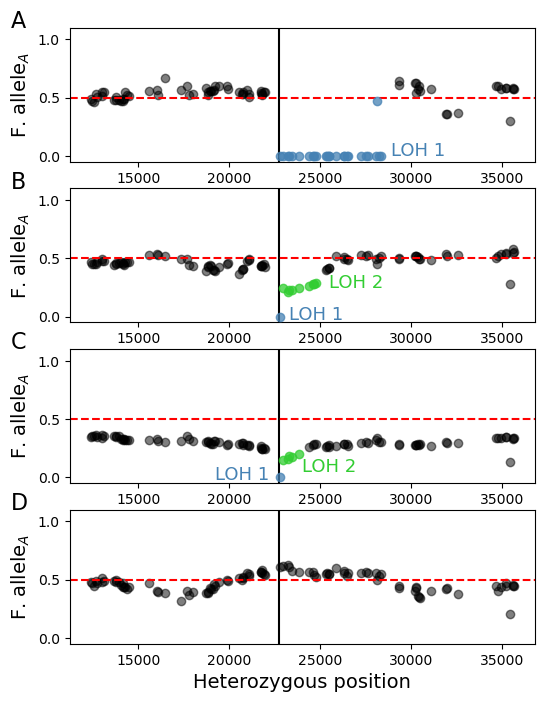

In [102]:
plt.figure(figsize=(6,8))

###########

ax1 = plt.subplot(411)

BB_1_pileup_df = HIS4_pileups_df_dict['HIS4_BB_1.HIS4.pileup']
BB_1_snp_pos_filter_pileup = BB_1_pileup_df['pos'].isin(list(snp_HIS4_region_dict.keys()))

BB_1_LOH_1_pos = (BB_1_pileup_df['pos'] >=22766) & (BB_1_pileup_df['pos'] <= 28326)

plt.scatter(BB_1_pileup_df[BB_1_LOH_1_pos&BB_1_snp_pos_filter_pileup]['pos'], BB_1_pileup_df[BB_1_LOH_1_pos&BB_1_snp_pos_filter_pileup]['ref_nt_freq'], zorder=9, color='steelblue', alpha=0.75)
plt.scatter(BB_1_pileup_df[(BB_1_snp_pos_filter_pileup)&~(BB_1_LOH_1_pos)]['pos'], BB_1_pileup_df[(BB_1_snp_pos_filter_pileup)&~(BB_1_LOH_1_pos)]['ref_nt_freq'], color='k', alpha=0.5)

plt.ylim(-0.05,1.1)

plt.axvline(22751, color='k', linestyle='-')
plt.axhline(0.5, color='red', linestyle='--')

plt.text(28900, 0, 'LOH 1', fontsize=13, color='steelblue')


plt.ylabel(r'F. allele$_{A}$', fontsize=14)
#plt.title('HIS1_A/HIS4_A 1', fontsize=14)
plt.text(8000, 1.1, 'A',fontsize =16)


####################################
ax1 = plt.subplot(412)

BB_2_pileup_df = HIS4_pileups_df_dict['HIS4_BB_2.HIS4.pileup']
BB_2_snp_pos_filter_pileup = BB_2_pileup_df['pos'].isin(list(snp_HIS4_region_dict.keys()))

BB_2_LOH_1_pos = (BB_2_pileup_df['pos'] >=22766) & (BB_2_pileup_df['pos'] <= 22766)
BB_2_LOH_2_pos = (BB_2_pileup_df['pos'] >=22766) & (BB_2_pileup_df['pos'] <= 24741)

plt.scatter(BB_2_pileup_df[BB_2_LOH_1_pos&BB_2_snp_pos_filter_pileup]['pos'], BB_2_pileup_df[BB_2_LOH_1_pos&BB_2_snp_pos_filter_pileup]['ref_nt_freq'], 
            zorder=9, color='steelblue', alpha=0.75)
plt.scatter(BB_2_pileup_df[BB_2_LOH_2_pos&~BB_2_LOH_1_pos&BB_2_snp_pos_filter_pileup]['pos'], BB_2_pileup_df[BB_2_LOH_2_pos&~BB_2_LOH_1_pos&BB_2_snp_pos_filter_pileup]['ref_nt_freq'], 
            zorder=9, color='limegreen', alpha=0.75)
plt.scatter(BB_2_pileup_df[(BB_2_snp_pos_filter_pileup)&~(BB_2_LOH_1_pos)&~BB_2_LOH_2_pos]['pos'], BB_2_pileup_df[(BB_2_snp_pos_filter_pileup)&~(BB_2_LOH_1_pos)&~BB_2_LOH_2_pos]['ref_nt_freq'],
            color='k', alpha=0.5)


plt.ylim(-0.05,1.1)
plt.axvline(22751, color='k', linestyle='-')
plt.axhline(0.5, color='red', linestyle='--')

plt.text(23250, -0.025, 'LOH 1', fontsize=13, color='steelblue')
plt.text(25500, 0.25, 'LOH 2', fontsize=13, color='limegreen')


plt.ylabel(r'F. allele$_{A}$', fontsize=14)
plt.text(8000, 1.1, 'B',fontsize =16)


############################################################

ax1 = plt.subplot(413)


BB_3_pileup_df = HIS4_pileups_df_dict['HIS4_BB_3.HIS4.pileup']
BB_3_snp_pos_filter_pileup = BB_3_pileup_df['pos'].isin(list(snp_HIS4_region_dict.keys()))


BB_3_LOH_1_pos = (BB_3_pileup_df['pos'] >=22766) & (BB_3_pileup_df['pos'] <= 22766)
BB_3_LOH_2_pos = (BB_3_pileup_df['pos'] >=22766) & (BB_3_pileup_df['pos'] <= 23841)

plt.scatter(BB_3_pileup_df[BB_3_LOH_1_pos&AA_3_snp_pos_filter_pileup]['pos'], BB_3_pileup_df[BB_3_LOH_1_pos&BB_3_snp_pos_filter_pileup]['ref_nt_freq'], 
            zorder=9, color='steelblue', alpha=0.75)
plt.scatter(BB_3_pileup_df[BB_3_LOH_2_pos&~BB_3_LOH_1_pos&BB_3_snp_pos_filter_pileup]['pos'], BB_3_pileup_df[BB_3_LOH_2_pos&~BB_3_LOH_1_pos&BB_3_snp_pos_filter_pileup]['ref_nt_freq'], 
            zorder=9, color='limegreen', alpha=0.75)
plt.scatter(BB_3_pileup_df[(BB_3_snp_pos_filter_pileup)&~(BB_3_LOH_1_pos)&~BB_3_LOH_2_pos]['pos'], BB_3_pileup_df[(BB_3_snp_pos_filter_pileup)&~(BB_3_LOH_1_pos)&~BB_3_LOH_2_pos]['ref_nt_freq'],
            color='k', alpha=0.5)


plt.ylim(-0.05,1.1)
plt.axvline(22751, color='k', linestyle='-')
plt.axhline(0.5, color='red', linestyle='--')


plt.text(19200, -0.025, 'LOH 1', fontsize=13, color='steelblue')
plt.text(24000, 0.05, 'LOH 2', fontsize=13, color='limegreen')


plt.ylabel(r'F. allele$_{A}$', fontsize=14)
plt.text(8000, 1.1, 'C',fontsize =16)


##################################################################################################
ax1 = plt.subplot(414)
BB_4_pileup_df = HIS4_pileups_df_dict['HIS4_BB_4.HIS4.pileup']
BB_4_snp_pos_filter_pileup = BB_4_pileup_df['pos'].isin(list(snp_HIS4_region_dict.keys()))

plt.scatter(BB_4_pileup_df[BB_4_snp_pos_filter_pileup]['pos'], BB_4_pileup_df[BB_4_snp_pos_filter_pileup]['ref_nt_freq'],
            color='k', alpha=0.5)

plt.ylim(-0.05,1.1)
plt.axvline(22751, color='k', linestyle='-')
plt.axhline(0.5, color='red', linestyle='--')


plt.ylabel(r'F. allele$_{A}$', fontsize=14)
plt.text(8000, 1.1, 'D',fontsize =16)

plt.xlabel('Heterozygous position', fontsize=14)

plt.savefig('./figures/LOH_tracts_BB.svg', format='svg', dpi=300)

In [103]:
BB_1_pileup_df[BB_1_pileup_df['pos'].isin([x for x in list(snp_HIS4_region_dict.keys()) if x>21500 and x <30000])]
#BB_1_LOH_1 covers from 22766 to 28326 = 5560

,chr,pos,ref_allele,depth,pileup,quality,nt_A_count,nt_T_count,nt_G_count,nt_C_count,nt_A_freq,nt_T_freq,nt_G_freq,nt_C_freq,ref_nt_freq,chr_name
11946,NC_032092.1,21712,A,72,"..TT,TTTTT.,,..,TT,.,T,T,.,,.T...T.,T..TTTTTT....",EK=MLNJOSKSPMSJS;SBLKPK7OOKLRJOIJKISMJIOOJLFNJ...,40,32,0,0,0.555556,0.444444,0.000000,0.000000,0.555556,Chr4
11991,NC_032092.1,21757,A,71,".G,GGGGG.,,..,GG,,G,G,.,,.G...G.,G..GGGGGG.GGG...",KJS?SSFJ?LQJBCISLKMK1SCJ2KG<BECDLPI?NG6LLS@G2D...,38,0,33,0,0.535211,0.000000,0.464789,0.000000,0.535211,Chr4
12021,NC_032092.1,21787,A,68,".TT,TTTTT.,,..,TT,,T,T,.,,.T...T.,T..TTTTT.TTT...",O7SSPMONMESMB<H?KONIK8SGNPOF3:GG>NLH?O0KGSF@D?...,36,32,0,0,0.529412,0.470588,0.000000,0.000000,0.529412,Chr4
12039,NC_032092.1,21805,A,73,"..CC,.CCCCC.,,..,CCC,,C,C,.,,.C...C,C..CCCCCC....",@.4EN8CJJGKOPQLH@<HLHKJJ:MOGRKFAKOIPSPI8PAK8LL...,38,0,0,35,0.520548,0.000000,0.000000,0.479452,0.520548,Chr4
12159,NC_032092.1,21925,A,75,"..GG,.GGGGG.,..,GGG,,G,G,.,,.G...G.,G..GGGGGG....",GSBQH9SQMOQEJ<LH9>H?MN?GPCSGSHI@FPLBRH<NKJMA2D...,41,0,34,0,0.546667,0.000000,0.453333,0.000000,0.546667,Chr4
12210,NC_032092.1,21976,C,73,"..GG,.GGGGG.,..,GGG,,G,G,.,,.G...G.,G..GGGGG.G...",K=BMS/LKJGJFHOLM</I:N>LDEENMSS;DILLPNM@INKLNEO...,0,0,33,40,0.000000,0.000000,0.452055,0.547945,0.547945,Chr4
13000,NC_032092.1,22766,A,75,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,<?;O8SMO=GBCJJGJ>JESSIJRCJLQCGAESCMJ5HMDAO9BSC...,0,0,0,75,0.000000,0.000000,0.000000,1.000000,0.000000,Chr4
13160,NC_032092.1,22926,G,72,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,A8OOSPKJMKJFN<J7K:J3MINJHIHKJFN5BNHG6GM@MB7ILK...,0,0,0,72,0.000000,0.000000,0.000000,1.000000,0.000000,Chr4
13433,NC_032092.1,23199,C,72,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,ME5K6HJCEDRDLMS3CO>JLMJPKICDNBK?2<:PL=HHHIK>H>...,0,0,72,0,0.000000,0.000000,1.000000,0.000000,0.000000,Chr4
13524,NC_032092.1,23290,G,75,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,K8L9SJLISMIMRLMI?;SQJ/SDSQLLK?KIMSKFSPJKKNGLLF...,75,0,0,0,1.000000,0.000000,0.000000,0.000000,0.000000,Chr4


In [104]:
BB_2_pileup_df[BB_2_pileup_df['pos'].isin([x for x in list(snp_HIS4_region_dict.keys()) if x>21500 and x <30000])]
#BB_2_LOH_1 covers from 22766 to 22766 = 1
#BB_2_LOH_2 covers from 22766 to 24741 = 1976

,chr,pos,ref_allele,depth,pileup,quality,nt_A_count,nt_T_count,nt_G_count,nt_C_count,nt_A_freq,nt_T_freq,nt_G_freq,nt_C_freq,ref_nt_freq,chr_name
11946,NC_032092.1,21712,A,135,"TT.T...,TTTT,.T.TT,,,,,TT,,.TTTTTT.T.T.,TTTT.T...",LGEAQGMSSJEJPLQSISSISF<SOPJQNC@MOHRASJC@<SGKMB...,59,76,0,0,0.437037,0.562963,0.000000,0.000000,0.437037,Chr4
11991,NC_032092.1,21757,A,133,"GG.G...,GGGG,.G.GG,,,,,GG,,.GGGGGG.G.G.,GGGG.G...",MDA;O?OHSF>PSMJJBOQJSE=NSSLMP7@ISNM@SS<?OS?RE7...,58,0,75,0,0.436090,0.000000,0.563910,0.000000,0.436090,Chr4
12021,NC_032092.1,21787,A,132,"TT.T...,TTTT,.T.TT,,,,,TT,,.TTTTTT.T.T.,TTTT.T...",OB;8L>LMKC?SSCQA?JSSSO>MNPSIM5<OJOK>PM3=JOLMB6...,58,74,0,0,0.439394,0.560606,0.000000,0.000000,0.439394,Chr4
12039,NC_032092.1,21805,A,131,"CCC...,CTCC,.C.CC,,,,,CC,,.CCCCCC.C.C.,CCCC.C,...",K?@NILGL=;MPMKR>LSDSK<SSSJOS=8NL@M:LI;AGNLSK<F...,57,1,0,73,0.435115,0.007634,0.000000,0.557252,0.435115,Chr4
12159,NC_032092.1,21925,A,133,"GG.G...,GGGG,.G.G,,,,,GG,,.GGGGGG.G.G.,GGGG.G,...",PEO;N<NGMNHIBPI?LKIELAJPMKKE8>KISLQKO75JNSK?7J...,60,0,73,0,0.451128,0.000000,0.548872,0.000000,0.451128,Chr4
12210,NC_032092.1,21976,C,130,"GGGG...GGGGG,.GG,,,,,GG,,GGGGGG.G.G.,GGGG.G,.,...",RES<S<SNGSI?KNHSOLKF7IMMNB;<PSMQJSH<BSNSSC:NLD...,0,0,75,55,0.000000,0.000000,0.576923,0.423077,0.423077,Chr4
13000,NC_032092.1,22766,A,129,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,KMP:D2HS4KSNS?K;IHEH=;@::KDD9=.IS<I7;G=BJCA?A=...,0,0,0,129,0.000000,0.000000,0.000000,1.000000,0.000000,Chr4
13160,NC_032092.1,22926,G,133,"CC.CCCCCC..CC,,,,CC,,.CCCCCCC.C.,CCCCC,.CCCCCC...",PM@=JNFM@JLHIS@JFLMGK8CGBDHFH6A@SJ?FAAKEHJECAL...,0,0,33,100,0.000000,0.000000,0.248120,0.751880,0.248120,Chr4
13433,NC_032092.1,23199,C,133,"GG.GGGGGG.G,,,GGG,,.GGGGGGGGGGGGGGG,GGGGGGGGG....",S@LBKIE7B@CF8LHEHHLL7B53E4FO8KSLLEAGH=DJHLN:LE...,0,0,105,28,0.000000,0.000000,0.789474,0.210526,0.210526,Chr4
13524,NC_032092.1,23290,G,137,"AA.AAAAA..AA,,,AAA,.AAAAAAAAAAAAAAAA,A,AAAAAAA...",PISBJSMSRL=SK>LSSHINJLPOJLDJCLSRDHQBKIASILPMGK...,106,0,31,0,0.773723,0.000000,0.226277,0.000000,0.226277,Chr4


In [105]:
BB_3_pileup_df[BB_3_pileup_df['pos'].isin([x for x in list(snp_HIS4_region_dict.keys()) if x>20000 and x <25000])]
#BB_2_LOH_1 covers from 22766 to 22766 = 1
#BB_2_LOH_2 covers from 22766 to 23841 = 1976

,chr,pos,ref_allele,depth,pileup,quality,nt_A_count,nt_T_count,nt_G_count,nt_C_count,nt_A_freq,nt_T_freq,nt_G_freq,nt_C_freq,ref_nt_freq,chr_name
10761,NC_032092.1,20527,A,283,"T,TT.T,TT.,T..TTTTT.T,T..TTT.TTTT.,.,TTTTTTT,,...",ISEM;LEI?@KEPNIN7DJ9JQS?LKHOKCMHJ>P?JLLHQRNPHS...,81,200,2,0,0.286219,0.706714,0.007067,0.000000,0.286219,Chr4
10940,NC_032092.1,20706,G,285,"C,CCC,C.C.,C..CCCCC.C,CC..CCC.CCCC.,.CCCCCCC,,...",BJFJLKG>?ANFNIMREFL<MNGLBJJKGNDPMI?S?EKIEKSJJP...,0,0,84,201,0.000000,0.000000,0.294737,0.705263,0.294737,Chr4
10959,NC_032092.1,20725,A,282,"G,GGGG.G.,G..GGGGGG,GG..GGG.GGGGG.,.GGGGGGG,,....",CFEIK7A?A?AOLLSA:ISESABLICGJBM=NJBN@DMGBISSDCB...,83,0,199,0,0.294326,0.000000,0.705674,0.000000,0.294326,Chr4
11003,NC_032092.1,20769,G,282,"C,CCCC.C.,C..CCCCC.C,CC.CCC.CCCCC.,.CCCCCCC,,....",LFEJJK8BBAEMKHS;NGDSMM=MPNJN=C@QG@E@=H<<GLL>FG...,0,0,79,203,0.000000,0.000000,0.280142,0.719858,0.280142,Chr4
11225,NC_032092.1,20991,g,268,"A,AAAA.A.,A..AAAAA.A,AA.A*A.AAAAA..A*AAAA,,.AA...",AI<<>K?@AFKPHIABJI=<L?CJ><FG87@O3AB@?2JK9IE0KK...,190,0,74,0,0.708955,0.000000,0.276119,0.000000,0.276119,Chr4
11289,NC_032092.1,21055,A,256,"GGGG.G.,G..GGGGG.GG.GGG.GGGG..GGGGG,,.GGGGGGGG...",=ECECC?HBM<HA=AK>=5NAJAC:FR4DEBHCQHJCFDJG;6:D@...,71,0,185,0,0.277344,0.000000,0.722656,0.000000,0.277344,Chr4
11308,NC_032092.1,21074,G,273,"A,AAA.A.,A..AAAA,.AAA.AAA.AAAAA..AAAAAA,,.AAAA...",I9HKIAG>BHGDKI?DH>/B?NIDCBHG2MS@DCEQF>L@B:HSRC...,199,0,74,0,0.728938,0.000000,0.271062,0.000000,0.271062,Chr4
11946,NC_032092.1,21712,A,280,"T,TT,T.,T..TTTT.TTT.TTT.TTTTT..TTTTT,,.T.TTTT,...",SJKNKBGLMKFJS>BISKKQFNIGJ4LSNCBMPGSS@ENASRMKOK...,74,206,0,0,0.264286,0.735714,0.000000,0.000000,0.264286,Chr4
11991,NC_032092.1,21757,A,268,"G,GG,G.,G..GGGGGGG.GGG.GGGGG.GGGGG,,G.GGGG,GGG...",MSGML9DPICNLP;=SO<MAS?>PSMOS8KGPIO=B<KSISIOB?S...,67,0,201,0,0.250000,0.000000,0.750000,0.000000,0.250000,Chr4
12021,NC_032092.1,21787,A,271,"T,TT,.T.,T..TTTT.TTT.TTT.TTTTT.TTTTT,T.T.TTTT,...",SNAGKC7>REHMKSELGOSEN:L=FLOFMO4PPFMS?@H<JLFK7N...,66,205,0,0,0.243542,0.756458,0.000000,0.000000,0.243542,Chr4


### Get heterozygous SNPs position list for samtools

In [508]:
SNP_count = 0
with open('./samtools_het_pos_list.txt', 'w') as dest:
    with open('./ref_genome_seq/C_albicans_SC5314_haplotype_variations.tab', 'r') as source:
        for line in source:
            if line.startswith('Hap A')==False:
                line_info=line.split('\t')
                chr_A = line_info[0]
                chr_B = line_info[3]
    
                position_A = int(line_info[2]) - 1
    
                if chr_A.strip('Ca22chr').strip('A_C_albicans_SC5314') != chr_B.strip('Ca22chr').strip('B_C_albicans_SC5314'):
                    print(line)
                    # all heterozygous sites are matched in terms of chromosome
    
                if line_info[6] == '1 nt subs':
                    SNP_count+=1
                    chr_ref_hap = chr_ID_to_genbank[chr_A]
                    dest.write(chr_ref_hap+'\t'+str(position_A)+'\n')

SNP_count               

50427

### Heterozygous SNPs allele A distributions

In [106]:
all_het_AA_1 = get_pileup_df('HIS4_AA_1.all_het.pileup').dropna(axis=0, subset=['ref_nt_freq'])
all_het_AA_2 = get_pileup_df('HIS4_AA_2.all_het.pileup').dropna(axis=0, subset=['ref_nt_freq'])
all_het_AA_3 = get_pileup_df('HIS4_AA_3.all_het.pileup').dropna(axis=0, subset=['ref_nt_freq'])
all_het_AA_4 = get_pileup_df('HIS4_AA_4.all_het.pileup').dropna(axis=0, subset=['ref_nt_freq'])

/tmp/ipykernel_210/1730992195.py:24: RuntimeWarning: invalid value encountered in scalar divide
  pileup_df.at[pos, 'nt_A_freq'] = pileup_df.at[pos, 'nt_A_count']/pileup_df.at[pos, 'depth']
/tmp/ipykernel_210/1730992195.py:25: RuntimeWarning: invalid value encountered in scalar divide
  pileup_df.at[pos, 'ref_nt_freq'] =pileup_df.at[pos, 'nt_A_count']/pileup_df.at[pos, 'depth']
/tmp/ipykernel_210/1730992195.py:29: RuntimeWarning: invalid value encountered in scalar divide
  pileup_df.at[pos, 'nt_T_freq'] = pileup_df.at[pos, 'nt_T_count']/pileup_df.at[pos, 'depth']
/tmp/ipykernel_210/1730992195.py:30: RuntimeWarning: invalid value encountered in scalar divide
  pileup_df.at[pos, 'ref_nt_freq'] =pileup_df.at[pos, 'nt_T_count']/pileup_df.at[pos, 'depth']
/tmp/ipykernel_210/1730992195.py:24: RuntimeWarning: invalid value encountered in scalar divide
  pileup_df.at[pos, 'nt_A_freq'] = pileup_df.at[pos, 'nt_A_count']/pileup_df.at[pos, 'depth']
/tmp/ipykernel_210/1730992195.py:25: RuntimeWarn

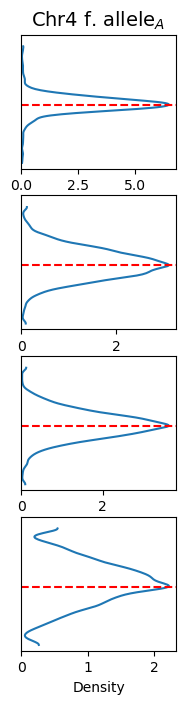

In [107]:
plt.figure(figsize=(2,8))

ax1 = plt.subplot(411)

sns.kdeplot(data = all_het_AA_1[all_het_AA_1['chr_name']=='Chr4'], y='ref_nt_freq', cut=0)
plt.ylim(-0.05, 1.1)
plt.yticks([],[])
plt.ylabel('')
plt.axhline(0.5, color='r', linestyle='--')
plt.title('Chr4 f. allele$_{A}$', fontsize=14)

ax2 = plt.subplot(412)

sns.kdeplot(data = all_het_AA_2[all_het_AA_2['chr_name']=='Chr4'], y='ref_nt_freq', cut=0)
plt.ylim(-0.05, 1.1)
plt.yticks([],[])
plt.ylabel('')
plt.axhline(0.5, color='r', linestyle='--')


ax3 = plt.subplot(413)

sns.kdeplot(data = all_het_AA_3[all_het_AA_3['chr_name']=='Chr4'], y='ref_nt_freq', cut=0)
plt.ylim(-0.05, 1.1)
plt.yticks([],[])
plt.ylabel('')
plt.axhline(0.5, color='r', linestyle='--')


ax4 = plt.subplot(414)

sns.kdeplot(data = all_het_AA_4[all_het_AA_4['chr_name']=='Chr4'], y='ref_nt_freq', cut=0)
plt.ylim(-0.05, 1.1)
plt.yticks([],[])
plt.ylabel('')
#plt.xlabel('Density',fontsize=14)
plt.axhline(0.5, color='r', linestyle='--')


plt.savefig('./figures/AA_density.svg', format='svg', dpi=300)

In [108]:
all_het_BB_1 = get_pileup_df('HIS4_BB_1.all_het.pileup').dropna(axis=0, subset=['ref_nt_freq'])
all_het_BB_2 = get_pileup_df('HIS4_BB_2.all_het.pileup').dropna(axis=0, subset=['ref_nt_freq'])
all_het_BB_3 = get_pileup_df('HIS4_BB_3.all_het.pileup').dropna(axis=0, subset=['ref_nt_freq'])
all_het_BB_4 = get_pileup_df('HIS4_BB_4.all_het.pileup').dropna(axis=0, subset=['ref_nt_freq'])

/tmp/ipykernel_210/1730992195.py:24: RuntimeWarning: invalid value encountered in scalar divide
  pileup_df.at[pos, 'nt_A_freq'] = pileup_df.at[pos, 'nt_A_count']/pileup_df.at[pos, 'depth']
/tmp/ipykernel_210/1730992195.py:25: RuntimeWarning: invalid value encountered in scalar divide
  pileup_df.at[pos, 'ref_nt_freq'] =pileup_df.at[pos, 'nt_A_count']/pileup_df.at[pos, 'depth']
/tmp/ipykernel_210/1730992195.py:29: RuntimeWarning: invalid value encountered in scalar divide
  pileup_df.at[pos, 'nt_T_freq'] = pileup_df.at[pos, 'nt_T_count']/pileup_df.at[pos, 'depth']
/tmp/ipykernel_210/1730992195.py:30: RuntimeWarning: invalid value encountered in scalar divide
  pileup_df.at[pos, 'ref_nt_freq'] =pileup_df.at[pos, 'nt_T_count']/pileup_df.at[pos, 'depth']
/tmp/ipykernel_210/1730992195.py:35: RuntimeWarning: invalid value encountered in scalar divide
  pileup_df.at[pos, 'nt_G_freq'] = pileup_df.at[pos, 'nt_G_count']/pileup_df.at[pos, 'depth']
/tmp/ipykernel_210/1730992195.py:36: RuntimeWarn

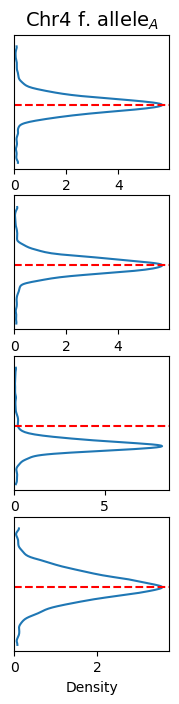

In [109]:
plt.figure(figsize=(2,8))

ax1 = plt.subplot(411)

sns.kdeplot(data = all_het_BB_1[all_het_BB_1['chr_name']=='Chr4'], y='ref_nt_freq', cut=0)
plt.ylim(-0.05, 1.1)
plt.yticks([],[])
plt.ylabel('')
plt.axhline(0.5, color='r', linestyle='--')
plt.title('Chr4 f. allele$_{A}$', fontsize=14)

ax2 = plt.subplot(412)

sns.kdeplot(data = all_het_BB_2[all_het_BB_2['chr_name']=='Chr4'], y='ref_nt_freq', cut=0)
plt.ylim(-0.05, 1.1)
plt.yticks([],[])
plt.ylabel('')
plt.axhline(0.5, color='r', linestyle='--')


ax3 = plt.subplot(413)

sns.kdeplot(data = all_het_BB_3[all_het_BB_3['chr_name']=='Chr4'], y='ref_nt_freq', cut=0)
plt.ylim(-0.05, 1.1)
plt.yticks([],[])
plt.ylabel('')
plt.axhline(0.5, color='r', linestyle='--')


ax4 = plt.subplot(414)

sns.kdeplot(data = all_het_BB_4[all_het_BB_4['chr_name']=='Chr4'], y='ref_nt_freq', cut=0)
plt.ylim(-0.05, 1.1)
plt.yticks([],[])
plt.ylabel('')
#plt.xlabel('Density',fontsize=14)
plt.axhline(0.5, color='r', linestyle='--')


plt.savefig('./figures/AA_density.svg', format='svg', dpi=300)

## KSR1 edited strains

In [112]:
snp_KSR1_region_dict = {}
# get SNPs around the KSR1 cut site

SNP_count=0
with open('./ref_genome_seq/C_albicans_SC5314_haplotype_variations.tab', 'r') as source:
    for line in source:
        if line.startswith('Hap A')==False:
            line_info=line.split('\t')
            chr_A = line_info[0]
            chr_B = line_info[3]

            position_A = int(line_info[2]) - 1

            if chr_A.strip('Ca22chr').strip('A_C_albicans_SC5314') != chr_B.strip('Ca22chr').strip('B_C_albicans_SC5314'):
                print(line)
                # all heterozygous sites are matched in terms of chromosome

            if line_info[6] == '1 nt subs' and line_info[0]=='Ca22chrRA_C_albicans_SC5314' and position_A in range(1593900,1613900):
                #                                                                                                  1603900
                SNP_count+=1

                nt_allele_A = line_info[7][1]
                nt_allele_B = line_info[8][1]

                snp_KSR1_region_dict[position_A] = [nt_allele_A, nt_allele_B]

                print(chr_A, position_A, nt_allele_A, nt_allele_B)


Ca22chrRA_C_albicans_SC5314 1594255 G A
Ca22chrRA_C_albicans_SC5314 1595971 G T
Ca22chrRA_C_albicans_SC5314 1596004 A G
Ca22chrRA_C_albicans_SC5314 1596021 C G
Ca22chrRA_C_albicans_SC5314 1597134 C T
Ca22chrRA_C_albicans_SC5314 1597901 A G
Ca22chrRA_C_albicans_SC5314 1597968 C T
Ca22chrRA_C_albicans_SC5314 1597991 T G
Ca22chrRA_C_albicans_SC5314 1598170 C T
Ca22chrRA_C_albicans_SC5314 1598243 G A
Ca22chrRA_C_albicans_SC5314 1598410 G A
Ca22chrRA_C_albicans_SC5314 1598503 C A
Ca22chrRA_C_albicans_SC5314 1598617 T C
Ca22chrRA_C_albicans_SC5314 1598653 A C
Ca22chrRA_C_albicans_SC5314 1598716 T C
Ca22chrRA_C_albicans_SC5314 1598750 T C
Ca22chrRA_C_albicans_SC5314 1598797 A G
Ca22chrRA_C_albicans_SC5314 1598806 A G
Ca22chrRA_C_albicans_SC5314 1598875 G A
Ca22chrRA_C_albicans_SC5314 1598920 A C
Ca22chrRA_C_albicans_SC5314 1599064 T C
Ca22chrRA_C_albicans_SC5314 1599175 C T
Ca22chrRA_C_albicans_SC5314 1600102 T C
Ca22chrRA_C_albicans_SC5314 1600122 A G
Ca22chrRA_C_albicans_SC5314 1600322 T C


In [113]:
KSR1_1_KSR1_pileup_df = get_pileup_df('KSR1_1.all_het.pileup')
KSR1_2_KSR1_pileup_df = get_pileup_df('KSR1_2.all_het.pileup')
KSR1_3_KSR1_pileup_df = get_pileup_df('KSR1_3.all_het.pileup')
KSR1_4_KSR1_pileup_df = get_pileup_df('KSR1_4.all_het.pileup')


/tmp/ipykernel_210/1730992195.py:24: RuntimeWarning: invalid value encountered in scalar divide
  pileup_df.at[pos, 'nt_A_freq'] = pileup_df.at[pos, 'nt_A_count']/pileup_df.at[pos, 'depth']
/tmp/ipykernel_210/1730992195.py:25: RuntimeWarning: invalid value encountered in scalar divide
  pileup_df.at[pos, 'ref_nt_freq'] =pileup_df.at[pos, 'nt_A_count']/pileup_df.at[pos, 'depth']
/tmp/ipykernel_210/1730992195.py:29: RuntimeWarning: invalid value encountered in scalar divide
  pileup_df.at[pos, 'nt_T_freq'] = pileup_df.at[pos, 'nt_T_count']/pileup_df.at[pos, 'depth']
/tmp/ipykernel_210/1730992195.py:30: RuntimeWarning: invalid value encountered in scalar divide
  pileup_df.at[pos, 'ref_nt_freq'] =pileup_df.at[pos, 'nt_T_count']/pileup_df.at[pos, 'depth']
/tmp/ipykernel_210/1730992195.py:35: RuntimeWarning: invalid value encountered in scalar divide
  pileup_df.at[pos, 'nt_G_freq'] = pileup_df.at[pos, 'nt_G_count']/pileup_df.at[pos, 'depth']
/tmp/ipykernel_210/1730992195.py:36: RuntimeWarn

### Figure 5 CDE

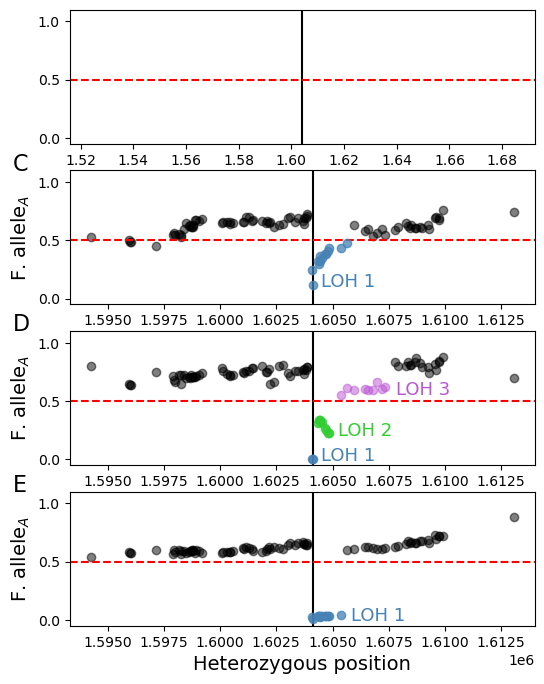

In [115]:
plt.figure(figsize=(6,8))



###########

ax1 = plt.subplot(411)

KSR1_1_KSR1_snp_pos_filter_pileup = KSR1_1_KSR1_pileup_df['pos'].isin(list(snp_KSR1_region_dict.keys()))


#plt.scatter(KSR1_1_KSR1_pileup_df[KSR1_1_KSR1_snp_pos_filter_pileup]['pos'], KSR1_1_KSR1_pileup_df[KSR1_1_KSR1_snp_pos_filter_pileup]['ref_nt_freq'], color='k', alpha=0.5)

plt.ylim(-0.05,1.1)

plt.axvline(1604111, color='k', linestyle='-')
plt.axhline(0.5, color='red', linestyle='--')


###############################################

ax1 = plt.subplot(412)

KSR1_2_KSR1_snp_pos_filter_pileup = KSR1_2_KSR1_pileup_df['pos'].isin(list(snp_KSR1_region_dict.keys()))

KSR1_2_LOH_1_pos = (KSR1_2_KSR1_pileup_df['pos'] >=1604101) & (KSR1_2_KSR1_pileup_df['pos'] <= 1605637)


plt.scatter(KSR1_2_KSR1_pileup_df[KSR1_2_LOH_1_pos&KSR1_2_KSR1_snp_pos_filter_pileup]['pos'], 
            KSR1_2_KSR1_pileup_df[KSR1_2_LOH_1_pos&KSR1_2_KSR1_snp_pos_filter_pileup]['ref_nt_freq'], zorder=9, color='steelblue', alpha=0.75)

plt.scatter(KSR1_2_KSR1_pileup_df[(KSR1_2_KSR1_snp_pos_filter_pileup)&~(KSR1_2_LOH_1_pos)]['pos'], 
            KSR1_2_KSR1_pileup_df[(KSR1_2_KSR1_snp_pos_filter_pileup)&~(KSR1_2_LOH_1_pos)]['ref_nt_freq'], color='k', alpha=0.5)

plt.ylim(-0.05,1.1)

plt.text(1604501, 0.1, 'LOH 1', fontsize=13, color='steelblue')

plt.axvline(1604111, color='k', linestyle='-')
plt.axhline(0.5, color='red', linestyle='--')

plt.ylabel(r'F. allele$_{A}$', fontsize=14)
plt.text(1590800, 1.1, 'C',fontsize =16)


###############################################

ax1 = plt.subplot(413)

KSR1_3_KSR1_snp_pos_filter_pileup = KSR1_3_KSR1_pileup_df['pos'].isin(list(snp_KSR1_region_dict.keys()))


KSR1_3_snp_pos_filter_pileup = KSR1_3_KSR1_pileup_df['pos'].isin(list(snp_KSR1_region_dict.keys()))

KSR1_3_LOH_1_pos = (KSR1_3_KSR1_pileup_df['pos'] >=1604101) & (KSR1_3_KSR1_pileup_df['pos'] <= 1604111)
KSR1_3_LOH_2_pos = (KSR1_3_KSR1_pileup_df['pos'] >=1604101) & (KSR1_3_KSR1_pileup_df['pos'] <= 1604822)
KSR1_3_LOH_3_pos = (KSR1_3_KSR1_pileup_df['pos'] >=1604101) & (KSR1_3_KSR1_pileup_df['pos'] <= 1607319)

plt.scatter(KSR1_3_KSR1_pileup_df[KSR1_3_LOH_1_pos&KSR1_3_snp_pos_filter_pileup]['pos'], 
            KSR1_3_KSR1_pileup_df[KSR1_3_LOH_1_pos&KSR1_3_snp_pos_filter_pileup]['ref_nt_freq'], 
            zorder=9, color='steelblue', alpha=0.75)

plt.scatter(KSR1_3_KSR1_pileup_df[KSR1_3_LOH_2_pos&~KSR1_3_LOH_1_pos&KSR1_3_snp_pos_filter_pileup]['pos'], 
            KSR1_3_KSR1_pileup_df[KSR1_3_LOH_2_pos&~KSR1_3_LOH_1_pos&KSR1_3_snp_pos_filter_pileup]['ref_nt_freq'], 
            zorder=9, color='limegreen', alpha=0.75)

plt.scatter(KSR1_3_KSR1_pileup_df[KSR1_3_LOH_3_pos&~KSR1_3_LOH_2_pos&~KSR1_3_LOH_1_pos&KSR1_3_snp_pos_filter_pileup]['pos'], 
            KSR1_3_KSR1_pileup_df[KSR1_3_LOH_3_pos&~KSR1_3_LOH_2_pos&~KSR1_3_LOH_1_pos&KSR1_3_snp_pos_filter_pileup]['ref_nt_freq'],
            color='mediumorchid', alpha=0.5)

plt.scatter(KSR1_3_KSR1_pileup_df[~KSR1_3_LOH_3_pos&~KSR1_3_LOH_2_pos&~KSR1_3_LOH_1_pos&KSR1_3_snp_pos_filter_pileup]['pos'], 
            KSR1_3_KSR1_pileup_df[~KSR1_3_LOH_3_pos&~KSR1_3_LOH_2_pos&~KSR1_3_LOH_1_pos&KSR1_3_snp_pos_filter_pileup]['ref_nt_freq'],
            color='k', alpha=0.5)


plt.ylim(-0.05,1.1)

plt.text(1604500, -0.01, 'LOH 1', fontsize=13, color='steelblue')
plt.text(1605250, 0.2, 'LOH 2', fontsize=13, color='limegreen')
plt.text(1607800, 0.55, 'LOH 3', fontsize=13, color='mediumorchid')


plt.axvline(1604111, color='k', linestyle='-')
plt.axhline(0.5, color='red', linestyle='--')

plt.ylabel(r'F. allele$_{A}$', fontsize=14)
plt.text(1590800, 1.1, 'D',fontsize =16)


###############################################

ax1 = plt.subplot(414)

KSR1_4_KSR1_snp_pos_filter_pileup = KSR1_4_KSR1_pileup_df['pos'].isin(list(snp_KSR1_region_dict.keys()))


KSR1_4_LOH_1_pos = (KSR1_4_KSR1_pileup_df['pos'] >=1604101) & (KSR1_4_KSR1_pileup_df['pos'] <= 1605364)


plt.scatter(KSR1_4_KSR1_pileup_df[KSR1_4_LOH_1_pos&KSR1_4_KSR1_snp_pos_filter_pileup]['pos'], 
            KSR1_4_KSR1_pileup_df[KSR1_4_LOH_1_pos&KSR1_4_KSR1_snp_pos_filter_pileup]['ref_nt_freq'], zorder=9, color='steelblue', alpha=0.75)

plt.scatter(KSR1_4_KSR1_pileup_df[(KSR1_4_KSR1_snp_pos_filter_pileup)&~(KSR1_4_LOH_1_pos)]['pos'], 
            KSR1_4_KSR1_pileup_df[(KSR1_4_KSR1_snp_pos_filter_pileup)&~(KSR1_4_LOH_1_pos)]['ref_nt_freq'], color='k', alpha=0.5)

plt.ylim(-0.05,1.1)

plt.text(1605801, -0.01, 'LOH 1', fontsize=13, color='steelblue')

plt.axvline(1604111, color='k', linestyle='-')
plt.axhline(0.5, color='red', linestyle='--')

plt.ylabel(r'F. allele$_{A}$', fontsize=14)
plt.text(1590800, 1.1, 'E',fontsize =16)
plt.xlabel('Heterozygous position', fontsize=14)

plt.savefig('./figures/LOH_tracts_KSR1.svg')

In [116]:
KSR1_2_KSR1_pileup_df[KSR1_2_KSR1_pileup_df['pos'].isin([x for x in list(snp_KSR1_region_dict.keys()) if x>=1602500 and x <1608000])]
#BB_1_LOH_1 covers from 1604101 to 1605637 = 1605637

,chr,pos,ref_allele,depth,pileup,quality,nt_A_count,nt_T_count,nt_G_count,nt_C_count,nt_A_freq,nt_T_freq,nt_G_freq,nt_C_freq,ref_nt_freq,chr_name
49542,NC_032096.1,1602601,C,52,".,...,...,.,,,.T,T..T,TT,T..,T.T,TTT,TT,..,TT,...",OHLIHELJLHLSHLF8IPMHH:RSELGEMIJILSMOKJSDFNIEPL...,0,19,0,33,0.000000,0.365385,0.000000,0.634615,0.634615,ChrR
49543,NC_032096.1,1602781,C,47,".,.T..,...,.,,.T,T..TTT,T..,TT,TT.,T,..,T,TTT.T",FLH>KKKENBSEMI=OD4IFBKL1D/MIGME?;<8@6DI79OAFJHD,0,17,0,30,0.000000,0.361702,0.000000,0.638298,0.638298,ChrR
49544,NC_032096.1,1603000,G,45,".,.T..,...T.,,.T,T..,,T,T..,T,,TT.,T,..,TTTT.",OINNMS@OLJSHS9PLJSKRA2L?HSLGSGKLKKHPBGI4FF9OB,0,14,31,0,0.000000,0.311111,0.688889,0.000000,0.688889,ChrR
49545,NC_032096.1,1603094,T,43,".,.G..,.G.G,,.G,..,,G,G..,G,,GG.,.,..,GGGG.",OLSJ7QGSFS=H=SLKSS6@LFIJSIK>J6>S>NILL?J3GEP,0,30,13,0,0.000000,0.697674,0.302326,0.000000,0.697674,ChrR
49546,NC_032096.1,1603343,G,44,".,.A..,.A.,.,,.A,A..,,A,..,A,AA.A.,C.,AAAA.A",GFBSGDAKOBKA<JFF:ODE=.K<AKHMI@RFI6K0DMJIMKDI,14,0,29,1,0.318182,0.000000,0.659091,0.022727,0.659091,ChrR
49547,NC_032096.1,1603460,T,39,".,.A..,.A.,.,.,A..,A,..,A,AA.,A,..,AAAA",FJN<GKSOJ2R>Q0NSQ;NJ5BLKOS>K=Q>S=@HDM:G,12,27,0,0,0.307692,0.692308,0.000000,0.000000,0.692308,ChrR
49548,NC_032096.1,1603674,A,36,".,.G..,.G,.,.G..,G,..G,GG.,G,.GGGG,.",PSLFHOJIECOFMFJJHO@IRNNKGLDAKEJGNCAF,24,0,12,0,0.666667,0.000000,0.333333,0.000000,0.666667,ChrR
49549,NC_032096.1,1603715,T,36,",CC..,...,,.C..,C..,C,CC.C.,.CCCC,.C",SKGJQIJHSIMLJNMIKELQISKLML@JMGQPLMSM,0,23,0,13,0.000000,0.638889,0.000000,0.361111,0.638889,ChrR
49550,NC_032096.1,1603734,a,39,".,.G..,...,.,.G..,G,..,G,GG.G.,.GGGG,.G",ISR9FJQIHHJIKJJJKFNGMJHLKIQKL@MHGSILKHI,27,0,12,0,0.692308,0.000000,0.307692,0.000000,0.692308,ChrR
49551,NC_032096.1,1603798,A,39,".,.G..,...,.,.G..,G,..,G,GG.G.,.GGGG,.G",MMSSQAJQEMPJIJSLJLJ@LK?OJPIIG@LFLKKMSIO,27,0,12,0,0.692308,0.000000,0.307692,0.000000,0.692308,ChrR


In [117]:
KSR1_3_KSR1_pileup_df[KSR1_3_KSR1_pileup_df['pos'].isin([x for x in list(snp_KSR1_region_dict.keys()) if x>=1602500 and x <1608000])]
#BB_1_LOH_1 covers from 1604101 to 1604111 = 10
#BB_1_LOH_1 covers from 1604101 to 1604822 = 722 
#BB_1_LOH_1 covers from 1604101 to 1607319 = 3219

,chr,pos,ref_allele,depth,pileup,quality,nt_A_count,nt_T_count,nt_G_count,nt_C_count,nt_A_freq,nt_T_freq,nt_G_freq,nt_C_freq,ref_nt_freq,chr_name
49543,NC_032096.1,1602601,C,30,"T..,.,,T,.,..,,T,T,...,,TT,,..",JDHMJESPFINJKINHQGDDLJKLHKKON@,0,6,0,24,0.000000,0.200000,0.000000,0.800000,0.800000,ChrR
49544,NC_032096.1,1602781,C,31,"T..,.,,T,.,..,,T,T,...,,TT,,..,",HKHHJR8IBLHI@KFRBLKGHHIOFFJCJ<D,0,6,0,25,0.000000,0.193548,0.000000,0.806452,0.806452,ChrR
49545,NC_032096.1,1603000,G,31,"T..,.,,T,.,.,T,T,...,,TT,,..,TT",MSGMPCSNAKMK9IHIISOMNSRNGPGPG1I,0,8,23,0,0.000000,0.258065,0.741935,0.000000,0.741935,ChrR
49546,NC_032096.1,1603094,T,32,"G..,.,,G,.,.,G,G,...,,GG,,..,GGG",7PSKSCCQ5SESH@J<QS7NGLG5J/PJIMPM,0,23,9,0,0.000000,0.718750,0.281250,0.000000,0.718750,ChrR
49547,NC_032096.1,1603343,G,29,"A..,.,A.,.,A,,..,,A.,,.,AAA,,",PEE/LSQC2HKELS<KNSDFP:GSPILRL,7,0,22,0,0.241379,0.000000,0.758621,0.000000,0.758621,ChrR
49548,NC_032096.1,1603460,T,29,"A.,,,A,.,.,A,,..,,A.,,.,AAA,,",H@HDID2GNSPGERKMSSGELNGKE4>MS,7,22,0,0,0.241379,0.758621,0.000000,0.000000,0.758621,ChrR
49549,NC_032096.1,1603674,A,30,"G.,.,,G.,.,G,,..,,G.,,.,GGG,,,",HSEP?SIMGPNFAPOOA/BH7SSSISJLLF,23,0,7,0,0.766667,0.000000,0.233333,0.000000,0.766667,ChrR
49550,NC_032096.1,1603715,T,31,"C.,.,,C,.,.,C,,..,,C.,,.,CCC,,,",MSPJKPO8SSSLKHLLNKKGPJFSNGKJMOO,0,24,0,7,0.000000,0.774194,0.000000,0.225806,0.774194,ChrR
49551,NC_032096.1,1603734,a,30,"G.,.,,GT.,.,G,,..,G.,,.,GGG,,,",JLJKKSF5HILHSISOKRIIJEKSHNHSLS,22,1,7,0,0.733333,0.033333,0.233333,0.000000,0.733333,ChrR
49552,NC_032096.1,1603798,A,30,"G.,.,,G,.,.,G,,..,G.,,.,GGG,,,",QPPGJKR6JJJSPSSELMJNJFFPHJISLH,23,0,7,0,0.766667,0.000000,0.233333,0.000000,0.766667,ChrR


In [118]:
KSR1_4_KSR1_pileup_df[KSR1_4_KSR1_pileup_df['pos'].isin([x for x in list(snp_KSR1_region_dict.keys()) if x>=1602500 and x <1607000])]
#KRS1_3_LOH_1 covers from 1604101 to 1605364 = 1264

,chr,pos,ref_allele,depth,pileup,quality,nt_A_count,nt_T_count,nt_G_count,nt_C_count,nt_A_freq,nt_T_freq,nt_G_freq,nt_C_freq,ref_nt_freq,chr_name
49542,NC_032096.1,1602601,C,146,"..,.,T.,TTT...,,,T..,.T.T,,T,,T,,,,T,T,,,TTTT,...",JK=GMQHJPNNHHLMSHPFSKNSIJSMLMIPKKLPSJIJDD=MNLK...,0,56,0,90,0.000000,0.383562,0.000000,0.616438,0.616438,ChrR
49543,NC_032096.1,1602781,C,141,"...,,TTTT.,,,T.,..TTT,,T,T,,,,T,T,,.,TTTT,TTT....",KFJKJLO5IHI@KEFH:F?S=HLKM2?MG=DKIH;ILHCJPIJMJC...,0,55,0,86,0.000000,0.390071,0.000000,0.609929,0.609929,ChrR
49544,NC_032096.1,1603000,G,144,"..,.,.,TTTT.,,,T.,..TTT,T,,T,,T,T,T,,.,TTT,,TT...",LL>SJSIKMKNE@ILEOLS?LFIQH5I@IHH.QIK;II>PSGKEHM...,0,51,93,0,0.000000,0.354167,0.645833,0.000000,0.645833,ChrR
49545,NC_032096.1,1603094,T,135,"...,.,GGGG.,,,G.,.GG,G,,G,,G,G,G,,.,GGG,,GGG.,...",<SSGPJCAEAILHHFSDS.J<E<IGJGKFHHLMNSFK;IHHIEQSI...,0,89,46,0,0.000000,0.659259,0.340741,0.000000,0.659259,ChrR
49546,NC_032096.1,1603343,G,141,"..,..,AAAA,,,A.,.AA,,A,,A,A,.,.,AAA,,.A.,.,,.,...",JF6>IMPSOHS;MSHK@LSSOIJPSJKMLLEJHLSMMCJD5DLMBI...,50,0,91,0,0.354610,0.000000,0.645390,0.000000,0.645390,ChrR
49547,NC_032096.1,1603460,T,136,"..,.,.AAAA.,,,.,.AA,,A,,A,A,.,,.,AAA,,.A.,,,.,...",I=DOM4SSEN6FOMFBJJSSMSGQM1SSOKKSKHJLN4;BFPIK7G...,46,90,0,0,0.338235,0.661765,0.000000,0.000000,0.661765,ChrR
49548,NC_032096.1,1603674,A,137,"...,.,GGGG.,,,.,.GG,,,G,,.,,.,GGG,,.G.,.,,.,.,...",GJSS8GEK=HLJH=FPSLFHGJ89JJKJLHIK2O.S8CNSOBLJ2?...,92,0,45,0,0.671533,0.000000,0.328467,0.000000,0.671533,ChrR
49549,NC_032096.1,1603715,T,142,".,.,.,CCCC.,,,.,.CC,C,,C,CC,,.,CCC,,.C.,.,,.,....",LF;P;AMLJMSKKQOKKIKSSJGFEHKLSSSOJJJJMPKKSONLJJ...,0,93,0,49,0.000000,0.654930,0.000000,0.345070,0.654930,ChrR
49550,NC_032096.1,1603734,a,146,"..,.,.,GGG.,,,.,.GG,G,,G,G,G,,.,GGG,,.G.,.,,.,...",ILOJLKPSOGFCIOKSOSPHJIFJEFNGJNSJALLHFKJKSPLKHH...,95,1,50,0,0.650685,0.006849,0.342466,0.000000,0.650685,ChrR
49551,NC_032096.1,1603798,A,148,"..,.,.,GGG.,,,.,.GG,G,,G,G,G,,.,GGG,,.G.,.,,.,...",IS9JJKJSFINSSLMLJNNLGMKIBIRHORPLHNRBINMPMPJOLH...,95,0,53,0,0.641892,0.000000,0.358108,0.000000,0.641892,ChrR


In [119]:
all_het_KRS1_1 = get_pileup_df('KSR1_1.all_het.pileup').dropna(axis=0, subset=['ref_nt_freq'])
all_het_KRS1_2 = get_pileup_df('KSR1_1.all_het.pileup').dropna(axis=0, subset=['ref_nt_freq'])
all_het_KRS1_3 = get_pileup_df('KSR1_1.all_het.pileup').dropna(axis=0, subset=['ref_nt_freq'])
all_het_KRS1_4 = get_pileup_df('KSR1_1.all_het.pileup').dropna(axis=0, subset=['ref_nt_freq'])

/tmp/ipykernel_210/1730992195.py:24: RuntimeWarning: invalid value encountered in scalar divide
  pileup_df.at[pos, 'nt_A_freq'] = pileup_df.at[pos, 'nt_A_count']/pileup_df.at[pos, 'depth']
/tmp/ipykernel_210/1730992195.py:25: RuntimeWarning: invalid value encountered in scalar divide
  pileup_df.at[pos, 'ref_nt_freq'] =pileup_df.at[pos, 'nt_A_count']/pileup_df.at[pos, 'depth']
/tmp/ipykernel_210/1730992195.py:29: RuntimeWarning: invalid value encountered in scalar divide
  pileup_df.at[pos, 'nt_T_freq'] = pileup_df.at[pos, 'nt_T_count']/pileup_df.at[pos, 'depth']
/tmp/ipykernel_210/1730992195.py:30: RuntimeWarning: invalid value encountered in scalar divide
  pileup_df.at[pos, 'ref_nt_freq'] =pileup_df.at[pos, 'nt_T_count']/pileup_df.at[pos, 'depth']
/tmp/ipykernel_210/1730992195.py:35: RuntimeWarning: invalid value encountered in scalar divide
  pileup_df.at[pos, 'nt_G_freq'] = pileup_df.at[pos, 'nt_G_count']/pileup_df.at[pos, 'depth']
/tmp/ipykernel_210/1730992195.py:36: RuntimeWarn

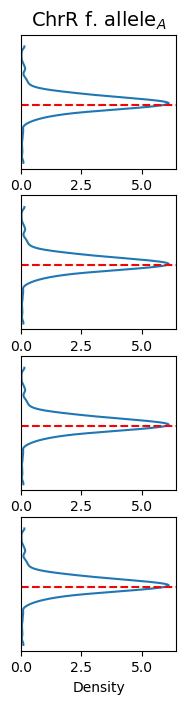

In [121]:
plt.figure(figsize=(2,8))

ax1 = plt.subplot(411)

sns.kdeplot(data = all_het_KRS1_1[all_het_KRS1_1['chr_name']=='ChrR'], y='ref_nt_freq', cut=0)
plt.ylim(-0.05, 1.1)
plt.yticks([],[])
plt.ylabel('')
plt.axhline(0.5, color='r', linestyle='--')
plt.title('ChrR f. allele$_{A}$', fontsize=14)

ax2 = plt.subplot(412)

sns.kdeplot(data = all_het_KRS1_2[all_het_KRS1_2['chr_name']=='ChrR'], y='ref_nt_freq', cut=0)
plt.ylim(-0.05, 1.1)
plt.yticks([],[])
plt.ylabel('')
plt.axhline(0.5, color='r', linestyle='--')


ax3 = plt.subplot(413)

sns.kdeplot(data = all_het_KRS1_3[all_het_KRS1_3['chr_name']=='ChrR'], y='ref_nt_freq', cut=0)
plt.ylim(-0.05, 1.1)
plt.yticks([],[])
plt.ylabel('')
plt.axhline(0.5, color='r', linestyle='--')


ax4 = plt.subplot(414)

sns.kdeplot(data = all_het_KRS1_4[all_het_KRS1_4['chr_name']=='ChrR'], y='ref_nt_freq', cut=0)
plt.ylim(-0.05, 1.1)
plt.yticks([],[])
plt.ylabel('')
#plt.xlabel('Density',fontsize=14)
plt.axhline(0.5, color='r', linestyle='--')


plt.savefig('./figures/KSR1_density.svg', format='svg', dpi=300)

In [122]:
extended_snp_KSR1_region_dict = {}


SNP_count=0
with open('./ref_genome_seq/C_albicans_SC5314_haplotype_variations.tab', 'r') as source:
    for line in source:
        if line.startswith('Hap A')==False:
            line_info=line.split('\t')
            chr_A = line_info[0]
            chr_B = line_info[3]

            position_A = int(line_info[2]) - 1

            if chr_A.strip('Ca22chr').strip('A_C_albicans_SC5314') != chr_B.strip('Ca22chr').strip('B_C_albicans_SC5314'):
                print(line)
                # all heterozygous sites are matched in terms of chromosome

            if line_info[6] == '1 nt subs' and line_info[0]=='Ca22chrRA_C_albicans_SC5314' and position_A in range(1543900,1663900):
                #                                                                                                  1603900
                SNP_count+=1

                nt_allele_A = line_info[7][1]
                nt_allele_B = line_info[8][1]

                extended_snp_KSR1_region_dict[position_A] = [nt_allele_A, nt_allele_B]

                #print(chr_A, position_A, nt_allele_A, nt_allele_B)

In [123]:
len(extended_snp_KSR1_region_dict)

589

### Figure S3

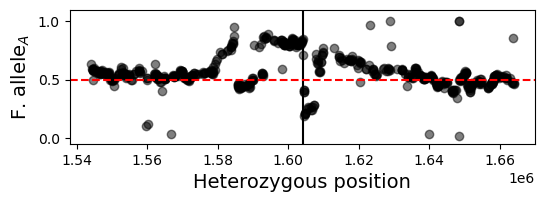

In [125]:
plt.figure(figsize=(6,8))



###########

ax1 = plt.subplot(411)

KSR1_1_extended_KSR1_snp_pos_filter_pileup = KSR1_1_KSR1_pileup_df['pos'].isin(list(extended_snp_KSR1_region_dict.keys()))


plt.scatter(KSR1_1_KSR1_pileup_df[KSR1_1_extended_KSR1_snp_pos_filter_pileup]['pos'], 
            KSR1_1_KSR1_pileup_df[KSR1_1_extended_KSR1_snp_pos_filter_pileup]['ref_nt_freq'], color='k', alpha=0.5)

plt.ylim(-0.05,1.1)

plt.axvline(1604111, color='k', linestyle='-')
plt.axhline(0.5, color='red', linestyle='--')
plt.ylabel(r'F. allele$_{A}$', fontsize=14)
plt.xlabel('Heterozygous position', fontsize=14)

plt.savefig('./figures/LOH_tracts_KSR1_sample_1.svg', format='svg')

### Figure 5 A

In [126]:
import random as random
random.seed(1)

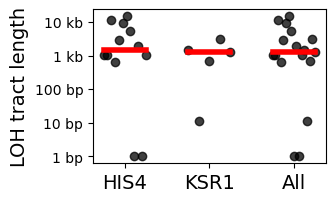

In [128]:


plt.figure(figsize = (3,2))

HIS4_length_dist =[1076,1076,11510,664,2865,9505,15092,5561,1,1976,1,1076]
KSR1_length_dist = [1537,11,722,3219,1264]

length_dist = [1076,1076,11510,664,2865,9505,15092,5561,1,1976,1,1076,1537,11,722,3219,1264]



plt.scatter([1+x for x in np.linspace(-0.25, 0.25, len(HIS4_length_dist))], np.log10(HIS4_length_dist), color='k', alpha=0.75)
plt.plot([0.75,1.25],[np.median(np.log10(HIS4_length_dist)), np.median(np.log10(HIS4_length_dist))], color='r', lw=4)

plt.scatter([2+x for x in np.linspace(-0.25, 0.25, len(KSR1_length_dist))], np.log10(KSR1_length_dist), color='k', alpha=0.75)
plt.plot([1.75,2.25],[np.median(np.log10(KSR1_length_dist)), np.median(np.log10(KSR1_length_dist))], color='r', lw=4)

plt.scatter([3+x for x in np.linspace(-0.25, 0.25, len(length_dist))], np.log10(length_dist), color='k', alpha=0.75)
plt.plot([2.75,3.25],[np.median(np.log10(length_dist)), np.median(np.log10(length_dist))], color='r', lw=4)


plt.yticks([0,1,2,3,4], ['1 bp', '10 bp', '100 bp', '1 kb', '10 kb'])
plt.ylabel('LOH tract length', fontsize=14)

plt.xticks([1,2,3], ['HIS4', 'KSR1', 'All'], fontsize=14)

plt.savefig('./figures/LOH_tract_dist.svg')